In [1]:
!pip install fedartml
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

import time
import pickle

import pandas as pd

import matplotlib.pyplot as plt

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
from scipy.stats import cramervonmises

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [3]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=16, verbose=0, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ]
    )
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=0, batch_size = 16, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from flwr.server.client_manager import ClientManager
import threading
from abc import ABC, abstractmethod
from logging import INFO
from typing import Dict, List, Optional
import random
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion

class SimpleClientManager(ClientManager):
    def __init__(self) -> None:
        self.clients: Dict[str, ClientProxy] = {}
        self._cv = threading.Condition()
        self.seed = 0

    def __len__(self) -> int:
        return len(self.clients)

    def num_available(self) -> int:
        return len(self)

    def wait_for(self, num_clients: int, timeout: int = 86400) -> bool:
        with self._cv:
            return self._cv.wait_for(
                lambda: len(self.clients) >= num_clients, timeout=timeout
            )

    def register(self, client: ClientProxy) -> bool:
        if client.cid in self.clients:
            return False

        self.clients[client.cid] = client
        with self._cv:
            self._cv.notify_all()

        return True

    def unregister(self, client: ClientProxy) -> None:
        if client.cid in self.clients:
            del self.clients[client.cid]

            with self._cv:
                self._cv.notify_all()

    def all(self) -> Dict[str, ClientProxy]:
        return self.clients

    def sample(
        self,
        num_clients: int,
        min_num_clients: Optional[int] = None,
        criterion: Optional[Criterion] = None,
    ) -> List[ClientProxy]:
        """Sample a number of Flower ClientProxy instances."""
        # Block until at least num_clients are connected.
        random.seed(self.seed)
        self.seed += 1
        if min_num_clients is None:
            min_num_clients = num_clients
        self.wait_for(min_num_clients)
        # Sample clients which meet the criterion
        available_cids = list(self.clients)
        if criterion is not None:
            available_cids = [
                cid for cid in available_cids if criterion.select(self.clients[cid])
            ]

        sampled_cids = random.sample(available_cids, num_clients)
        #print(sampled_cids)
        return [self.clients[cid] for cid in sampled_cids]

In [10]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 20

# Define percentage of noniid to be used
Percent_noniid = 1000

Alpha = 1

In [11]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "dirichlet", alpha = Alpha)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


In [7]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
from flwr.common import (
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 100
seed_value = 42
tf.random.set_seed(seed_value)
initial_model = get_model()

# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    seed_value = 42
    tf.random.set_seed(seed_value)
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy= fl.server.strategy.FedYogi(
        fraction_fit=0.3,  # Sample 100% of available clients for training
        fraction_evaluate=0.05,  # Sample 50% of available clients for evaluation
        min_fit_clients=6,
        min_evaluate_clients = 1,
        min_available_clients = 20,
        evaluate_fn=evaluate_DNN_CL,
        initial_parameters  = ndarrays_to_parameters(initial_model.get_weights())
)
client_manager = SimpleClientManager()

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-02-24 15:12:03,654 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-02-24 15:12:08,072	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-24 15:12:11,055 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3923129548.0, 'memory': 7846259099.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3923129548.0, 'memory': 7846259099.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-24 15:12:11,068 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-24

@@@@@@ Server-side evaluation loss 2.3225555419921875 / accuracy 0.1009 @@@@@@


(DefaultActor pid=109243) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=109243)   client = check_clientfn_returns_client(client_fn(cid))
DEBUG flwr 2024-02-24 15:12:37,902 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-02-24 15:12:37,914 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
INFO flwr 2024-02-24 15:12:39,559 | server.py:125 | fit progress: (1, 2.107563, {'accuracy': 0.4439, 'precision': 0.6767279354458162, 'recall': 0.4439, 'f1score': 0.5102900931417019}, 16.56723539199993)
INFO:flwr:fit progress: (1, 2.1

@@@@@@ Server-side evaluation loss 2.107563018798828 / accuracy 0.4439 @@@@@@


DEBUG flwr 2024-02-24 15:12:40,953 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-02-24 15:12:40,957 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-24 15:12:40,962 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 2.1076 - accuracy: 0.4439 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:12:51,805 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures
INFO flwr 2024-02-24 15:12:53,439 | server.py:125 | fit progress: (2, 1.4859545, {'accuracy': 0.6073, 'precision': 0.867404679898253, 'recall': 0.6073, 'f1score': 0.6678153558293825}, 30.446771087999878)
INFO:flwr:fit progress: (2, 1.4859545, {'accuracy': 0.6073, 'precision': 0.867404679898253, 'recall': 0.6073, 'f1score': 0.6678153558293825}, 30.446771087999878)
DEBUG flwr 2024-02-24 15:12:53,444 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.4859545230865479 / accuracy 0.6073 @@@@@@


DEBUG flwr 2024-02-24 15:12:55,543 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:12:55,546 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 1.4860 - accuracy: 0.6073 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:13:05,544 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures
INFO flwr 2024-02-24 15:13:08,326 | server.py:125 | fit progress: (3, 1.1827346, {'accuracy': 0.6824, 'precision': 0.8984001465339941, 'recall': 0.6824, 'f1score': 0.7385866454045592}, 45.33342463200006)
INFO:flwr:fit progress: (3, 1.1827346, {'accuracy': 0.6824, 'precision': 0.8984001465339941, 'recall': 0.6824, 'f1score': 0.7385866454045592}, 45.33342463200006)
DEBUG flwr 2024-02-24 15:13:08,330 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.1827346086502075 / accuracy 0.6824 @@@@@@


DEBUG flwr 2024-02-24 15:13:09,688 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:13:09,691 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 1.1827 - accuracy: 0.6824 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:13:20,547 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures
INFO flwr 2024-02-24 15:13:22,153 | server.py:125 | fit progress: (4, 1.3890219, {'accuracy': 0.7744, 'precision': 0.9060039104766046, 'recall': 0.7744, 'f1score': 0.806169785048031}, 59.160868115000085)
INFO:flwr:fit progress: (4, 1.3890219, {'accuracy': 0.7744, 'precision': 0.9060039104766046, 'recall': 0.7744, 'f1score': 0.806169785048031}, 59.160868115000085)
DEBUG flwr 2024-02-24 15:13:22,157 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.389021873474121 / accuracy 0.7744 @@@@@@


DEBUG flwr 2024-02-24 15:13:23,503 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:13:23,506 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 1.3896 - accuracy: 0.7744 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:13:34,652 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures
INFO flwr 2024-02-24 15:13:37,381 | server.py:125 | fit progress: (5, 1.4974898, {'accuracy': 0.8319, 'precision': 0.9349370421273676, 'recall': 0.8319, 'f1score': 0.8648976716624407}, 74.38870597799996)
INFO:flwr:fit progress: (5, 1.4974898, {'accuracy': 0.8319, 'precision': 0.9349370421273676, 'recall': 0.8319, 'f1score': 0.8648976716624407}, 74.38870597799996)
DEBUG flwr 2024-02-24 15:13:37,386 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.4974898099899292 / accuracy 0.8319 @@@@@@


DEBUG flwr 2024-02-24 15:13:38,807 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:13:38,811 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 1.5372 - accuracy: 0.8319 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:13:49,949 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures
INFO flwr 2024-02-24 15:13:51,576 | server.py:125 | fit progress: (6, 1.2202027, {'accuracy': 0.8534, 'precision': 0.9522035340040901, 'recall': 0.8534, 'f1score': 0.8909935500596348}, 88.5834766500002)
INFO:flwr:fit progress: (6, 1.2202027, {'accuracy': 0.8534, 'precision': 0.9522035340040901, 'recall': 0.8534, 'f1score': 0.8909935500596348}, 88.5834766500002)
DEBUG flwr 2024-02-24 15:13:51,579 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.2202026844024658 / accuracy 0.8534 @@@@@@


DEBUG flwr 2024-02-24 15:13:52,949 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:13:52,953 | server.py:222 | fit_round 7: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 1.2598 - accuracy: 0.8534 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:14:03,563 | server.py:236 | fit_round 7 received 6 results and 0 failures
DEBUG:flwr:fit_round 7 received 6 results and 0 failures
INFO flwr 2024-02-24 15:14:05,207 | server.py:125 | fit progress: (7, 0.7010926, {'accuracy': 0.8738, 'precision': 0.9473921300704542, 'recall': 0.8738, 'f1score': 0.898485946808072}, 102.21427311700018)
INFO:flwr:fit progress: (7, 0.7010926, {'accuracy': 0.8738, 'precision': 0.9473921300704542, 'recall': 0.8738, 'f1score': 0.898485946808072}, 102.21427311700018)
DEBUG flwr 2024-02-24 15:14:05,210 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.7010926008224487 / accuracy 0.8738 @@@@@@


DEBUG flwr 2024-02-24 15:14:06,715 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:14:06,720 | server.py:222 | fit_round 8: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.7211 - accuracy: 0.8738 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:14:17,827 | server.py:236 | fit_round 8 received 6 results and 0 failures
DEBUG:flwr:fit_round 8 received 6 results and 0 failures
INFO flwr 2024-02-24 15:14:20,579 | server.py:125 | fit progress: (8, 0.3396792, {'accuracy': 0.9226, 'precision': 0.9393682255184426, 'recall': 0.9226, 'f1score': 0.926164745212125}, 117.58627385999989)
INFO:flwr:fit progress: (8, 0.3396792, {'accuracy': 0.9226, 'precision': 0.9393682255184426, 'recall': 0.9226, 'f1score': 0.926164745212125}, 117.58627385999989)
DEBUG flwr 2024-02-24 15:14:20,582 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.33967921137809753 / accuracy 0.9226 @@@@@@


DEBUG flwr 2024-02-24 15:14:21,935 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:14:21,941 | server.py:222 | fit_round 9: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.3468 - accuracy: 0.9226 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:14:33,047 | server.py:236 | fit_round 9 received 6 results and 0 failures
DEBUG:flwr:fit_round 9 received 6 results and 0 failures
INFO flwr 2024-02-24 15:14:35,776 | server.py:125 | fit progress: (9, 0.20455088, {'accuracy': 0.9504, 'precision': 0.9516903638374071, 'recall': 0.9504, 'f1score': 0.9506418446836403}, 132.7832695850002)
INFO:flwr:fit progress: (9, 0.20455088, {'accuracy': 0.9504, 'precision': 0.9516903638374071, 'recall': 0.9504, 'f1score': 0.9506418446836403}, 132.7832695850002)
DEBUG flwr 2024-02-24 15:14:35,779 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.2045508772134781 / accuracy 0.9504 @@@@@@


DEBUG flwr 2024-02-24 15:14:37,140 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:14:37,143 | server.py:222 | fit_round 10: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.2060 - accuracy: 0.9504 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:14:48,800 | server.py:236 | fit_round 10 received 6 results and 0 failures
DEBUG:flwr:fit_round 10 received 6 results and 0 failures
INFO flwr 2024-02-24 15:14:51,549 | server.py:125 | fit progress: (10, 0.18813935, {'accuracy': 0.9489, 'precision': 0.9499409779020301, 'recall': 0.9489, 'f1score': 0.9488712839688169}, 148.55631505500014)
INFO:flwr:fit progress: (10, 0.18813935, {'accuracy': 0.9489, 'precision': 0.9499409779020301, 'recall': 0.9489, 'f1score': 0.9488712839688169}, 148.55631505500014)
DEBUG flwr 2024-02-24 15:14:51,552 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.18813934922218323 / accuracy 0.9489 @@@@@@


DEBUG flwr 2024-02-24 15:14:52,921 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:14:52,924 | server.py:222 | fit_round 11: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1883 - accuracy: 0.9489 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:15:04,607 | server.py:236 | fit_round 11 received 6 results and 0 failures
DEBUG:flwr:fit_round 11 received 6 results and 0 failures
INFO flwr 2024-02-24 15:15:07,344 | server.py:125 | fit progress: (11, 0.19465007, {'accuracy': 0.9445, 'precision': 0.9461677517316525, 'recall': 0.9445, 'f1score': 0.9444304863096038}, 164.3515118350001)
INFO:flwr:fit progress: (11, 0.19465007, {'accuracy': 0.9445, 'precision': 0.9461677517316525, 'recall': 0.9445, 'f1score': 0.9444304863096038}, 164.3515118350001)
DEBUG flwr 2024-02-24 15:15:07,347 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1946500688791275 / accuracy 0.9445 @@@@@@


DEBUG flwr 2024-02-24 15:15:09,121 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:15:09,125 | server.py:222 | fit_round 12: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.1946 - accuracy: 0.9445 - 1s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:15:20,098 | server.py:236 | fit_round 12 received 6 results and 0 failures
DEBUG:flwr:fit_round 12 received 6 results and 0 failures
INFO flwr 2024-02-24 15:15:22,943 | server.py:125 | fit progress: (12, 0.19539295, {'accuracy': 0.9427, 'precision': 0.9447527738472565, 'recall': 0.9427, 'f1score': 0.9426083184186855}, 179.95028989699995)
INFO:flwr:fit progress: (12, 0.19539295, {'accuracy': 0.9427, 'precision': 0.9447527738472565, 'recall': 0.9427, 'f1score': 0.9426083184186855}, 179.95028989699995)
DEBUG flwr 2024-02-24 15:15:22,947 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.19539295136928558 / accuracy 0.9427 @@@@@@


DEBUG flwr 2024-02-24 15:15:24,271 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:15:24,273 | server.py:222 | fit_round 13: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 13: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1954 - accuracy: 0.9427 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:15:35,269 | server.py:236 | fit_round 13 received 6 results and 0 failures
DEBUG:flwr:fit_round 13 received 6 results and 0 failures
INFO flwr 2024-02-24 15:15:38,000 | server.py:125 | fit progress: (13, 0.1692506, {'accuracy': 0.9512, 'precision': 0.952700783848852, 'recall': 0.9512, 'f1score': 0.9511818014237706}, 195.0073593410002)
INFO:flwr:fit progress: (13, 0.1692506, {'accuracy': 0.9512, 'precision': 0.952700783848852, 'recall': 0.9512, 'f1score': 0.9511818014237706}, 195.0073593410002)
DEBUG flwr 2024-02-24 15:15:38,003 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.16925059258937836 / accuracy 0.9512 @@@@@@


DEBUG flwr 2024-02-24 15:15:39,386 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:15:39,390 | server.py:222 | fit_round 14: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 14: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1693 - accuracy: 0.9512 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:15:50,704 | server.py:236 | fit_round 14 received 6 results and 0 failures
DEBUG:flwr:fit_round 14 received 6 results and 0 failures
INFO flwr 2024-02-24 15:15:52,332 | server.py:125 | fit progress: (14, 0.14401776, {'accuracy': 0.9575, 'precision': 0.9589255718522097, 'recall': 0.9575, 'f1score': 0.9576389718994341}, 209.33973482300007)
INFO:flwr:fit progress: (14, 0.14401776, {'accuracy': 0.9575, 'precision': 0.9589255718522097, 'recall': 0.9575, 'f1score': 0.9576389718994341}, 209.33973482300007)
DEBUG flwr 2024-02-24 15:15:52,336 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14401775598526 / accuracy 0.9575 @@@@@@


DEBUG flwr 2024-02-24 15:15:53,735 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:15:53,738 | server.py:222 | fit_round 15: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 15: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.1440 - accuracy: 0.9575 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:16:05,178 | server.py:236 | fit_round 15 received 6 results and 0 failures
DEBUG:flwr:fit_round 15 received 6 results and 0 failures
INFO flwr 2024-02-24 15:16:07,918 | server.py:125 | fit progress: (15, 0.121028006, {'accuracy': 0.9616, 'precision': 0.9628159816773425, 'recall': 0.9616, 'f1score': 0.9617329655373804}, 224.92611086399984)
INFO:flwr:fit progress: (15, 0.121028006, {'accuracy': 0.9616, 'precision': 0.9628159816773425, 'recall': 0.9616, 'f1score': 0.9617329655373804}, 224.92611086399984)
DEBUG flwr 2024-02-24 15:16:07,925 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12102800607681274 / accuracy 0.9616 @@@@@@


DEBUG flwr 2024-02-24 15:16:09,704 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:16:09,710 | server.py:222 | fit_round 16: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 16: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.1210 - accuracy: 0.9616 - 2s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:16:19,535 | server.py:236 | fit_round 16 received 6 results and 0 failures
DEBUG:flwr:fit_round 16 received 6 results and 0 failures
INFO flwr 2024-02-24 15:16:21,727 | server.py:125 | fit progress: (16, 0.10870195, {'accuracy': 0.9655, 'precision': 0.966480965860464, 'recall': 0.9655, 'f1score': 0.9656110147489404}, 238.73470352899994)
INFO:flwr:fit progress: (16, 0.10870195, {'accuracy': 0.9655, 'precision': 0.966480965860464, 'recall': 0.9655, 'f1score': 0.9656110147489404}, 238.73470352899994)
DEBUG flwr 2024-02-24 15:16:21,730 | server.py:173 | evaluate_round 16: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 16: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10870195180177689 / accuracy 0.9655 @@@@@@


DEBUG flwr 2024-02-24 15:16:23,112 | server.py:187 | evaluate_round 16 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:16:23,115 | server.py:222 | fit_round 17: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 17: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1087 - accuracy: 0.9655 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:16:34,550 | server.py:236 | fit_round 17 received 6 results and 0 failures
DEBUG:flwr:fit_round 17 received 6 results and 0 failures
INFO flwr 2024-02-24 15:16:36,154 | server.py:125 | fit progress: (17, 0.10398412, {'accuracy': 0.9673, 'precision': 0.9681313078831081, 'recall': 0.9673, 'f1score': 0.9673865736290063}, 253.16150376899986)
INFO:flwr:fit progress: (17, 0.10398412, {'accuracy': 0.9673, 'precision': 0.9681313078831081, 'recall': 0.9673, 'f1score': 0.9673865736290063}, 253.16150376899986)
DEBUG flwr 2024-02-24 15:16:36,158 | server.py:173 | evaluate_round 17: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 17: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10398411750793457 / accuracy 0.9673 @@@@@@


DEBUG flwr 2024-02-24 15:16:37,536 | server.py:187 | evaluate_round 17 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:16:37,539 | server.py:222 | fit_round 18: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 18: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.1040 - accuracy: 0.9673 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:16:49,435 | server.py:236 | fit_round 18 received 6 results and 0 failures
DEBUG:flwr:fit_round 18 received 6 results and 0 failures
INFO flwr 2024-02-24 15:16:52,177 | server.py:125 | fit progress: (18, 0.10124971, {'accuracy': 0.9685, 'precision': 0.9692911501200486, 'recall': 0.9685, 'f1score': 0.9685991534100765}, 269.18486024899994)
INFO:flwr:fit progress: (18, 0.10124971, {'accuracy': 0.9685, 'precision': 0.9692911501200486, 'recall': 0.9685, 'f1score': 0.9685991534100765}, 269.18486024899994)
DEBUG flwr 2024-02-24 15:16:52,180 | server.py:173 | evaluate_round 18: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 18: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10124970972537994 / accuracy 0.9685 @@@@@@


DEBUG flwr 2024-02-24 15:16:53,568 | server.py:187 | evaluate_round 18 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:16:53,571 | server.py:222 | fit_round 19: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 19: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1016 - accuracy: 0.9685 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:17:05,245 | server.py:236 | fit_round 19 received 6 results and 0 failures
DEBUG:flwr:fit_round 19 received 6 results and 0 failures
INFO flwr 2024-02-24 15:17:06,865 | server.py:125 | fit progress: (19, 0.10209899, {'accuracy': 0.9704, 'precision': 0.9714010002427432, 'recall': 0.9704, 'f1score': 0.9705602003339987}, 283.8726686670002)
INFO:flwr:fit progress: (19, 0.10209899, {'accuracy': 0.9704, 'precision': 0.9714010002427432, 'recall': 0.9704, 'f1score': 0.9705602003339987}, 283.8726686670002)
DEBUG flwr 2024-02-24 15:17:06,869 | server.py:173 | evaluate_round 19: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 19: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1020989865064621 / accuracy 0.9704 @@@@@@


DEBUG flwr 2024-02-24 15:17:08,388 | server.py:187 | evaluate_round 19 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:17:08,391 | server.py:222 | fit_round 20: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 20: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1026 - accuracy: 0.9704 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:17:20,179 | server.py:236 | fit_round 20 received 6 results and 0 failures
DEBUG:flwr:fit_round 20 received 6 results and 0 failures
INFO flwr 2024-02-24 15:17:22,969 | server.py:125 | fit progress: (20, 0.11136943, {'accuracy': 0.968, 'precision': 0.9700652296446127, 'recall': 0.968, 'f1score': 0.9683386378862546}, 299.9771681850002)
INFO:flwr:fit progress: (20, 0.11136943, {'accuracy': 0.968, 'precision': 0.9700652296446127, 'recall': 0.968, 'f1score': 0.9683386378862546}, 299.9771681850002)
DEBUG flwr 2024-02-24 15:17:22,974 | server.py:173 | evaluate_round 20: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 20: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11136943101882935 / accuracy 0.968 @@@@@@


DEBUG flwr 2024-02-24 15:17:24,417 | server.py:187 | evaluate_round 20 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:17:24,422 | server.py:222 | fit_round 21: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 21: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1120 - accuracy: 0.9680 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:17:36,588 | server.py:236 | fit_round 21 received 6 results and 0 failures
DEBUG:flwr:fit_round 21 received 6 results and 0 failures
INFO flwr 2024-02-24 15:17:38,211 | server.py:125 | fit progress: (21, 0.119647935, {'accuracy': 0.9659, 'precision': 0.9687543512822978, 'recall': 0.9659, 'f1score': 0.9664059587528638}, 315.2185216990001)
INFO:flwr:fit progress: (21, 0.119647935, {'accuracy': 0.9659, 'precision': 0.9687543512822978, 'recall': 0.9659, 'f1score': 0.9664059587528638}, 315.2185216990001)
DEBUG flwr 2024-02-24 15:17:38,217 | server.py:173 | evaluate_round 21: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 21: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11964793503284454 / accuracy 0.9659 @@@@@@


DEBUG flwr 2024-02-24 15:17:39,564 | server.py:187 | evaluate_round 21 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:17:39,567 | server.py:222 | fit_round 22: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 22: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.1201 - accuracy: 0.9659 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:17:51,150 | server.py:236 | fit_round 22 received 6 results and 0 failures
DEBUG:flwr:fit_round 22 received 6 results and 0 failures
INFO flwr 2024-02-24 15:17:53,886 | server.py:125 | fit progress: (22, 0.12269779, {'accuracy': 0.9651, 'precision': 0.9685936702323523, 'recall': 0.9651, 'f1score': 0.96580053774802}, 330.89414995000016)
INFO:flwr:fit progress: (22, 0.12269779, {'accuracy': 0.9651, 'precision': 0.9685936702323523, 'recall': 0.9651, 'f1score': 0.96580053774802}, 330.89414995000016)
DEBUG flwr 2024-02-24 15:17:53,891 | server.py:173 | evaluate_round 22: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 22: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12269779294729233 / accuracy 0.9651 @@@@@@


DEBUG flwr 2024-02-24 15:17:55,237 | server.py:187 | evaluate_round 22 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:17:55,240 | server.py:222 | fit_round 23: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 23: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.1230 - accuracy: 0.9651 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:18:07,841 | server.py:236 | fit_round 23 received 6 results and 0 failures
DEBUG:flwr:fit_round 23 received 6 results and 0 failures
INFO flwr 2024-02-24 15:18:10,012 | server.py:125 | fit progress: (23, 0.11640774, {'accuracy': 0.9664, 'precision': 0.9696087625212458, 'recall': 0.9664, 'f1score': 0.9670328744937826}, 347.0198334480001)
INFO:flwr:fit progress: (23, 0.11640774, {'accuracy': 0.9664, 'precision': 0.9696087625212458, 'recall': 0.9664, 'f1score': 0.9670328744937826}, 347.0198334480001)
DEBUG flwr 2024-02-24 15:18:10,018 | server.py:173 | evaluate_round 23: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 23: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11640773713588715 / accuracy 0.9664 @@@@@@


DEBUG flwr 2024-02-24 15:18:11,533 | server.py:187 | evaluate_round 23 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:18:11,536 | server.py:222 | fit_round 24: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 24: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.1164 - accuracy: 0.9664 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:18:22,646 | server.py:236 | fit_round 24 received 6 results and 0 failures
DEBUG:flwr:fit_round 24 received 6 results and 0 failures
INFO flwr 2024-02-24 15:18:24,267 | server.py:125 | fit progress: (24, 0.08783289, {'accuracy': 0.9748, 'precision': 0.9759526754393341, 'recall': 0.9748, 'f1score': 0.9749950650343384}, 361.27507528900014)
INFO:flwr:fit progress: (24, 0.08783289, {'accuracy': 0.9748, 'precision': 0.9759526754393341, 'recall': 0.9748, 'f1score': 0.9749950650343384}, 361.27507528900014)
DEBUG flwr 2024-02-24 15:18:24,271 | server.py:173 | evaluate_round 24: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 24: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08783289045095444 / accuracy 0.9748 @@@@@@


DEBUG flwr 2024-02-24 15:18:25,659 | server.py:187 | evaluate_round 24 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:18:25,665 | server.py:222 | fit_round 25: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 25: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0878 - accuracy: 0.9748 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:18:37,153 | server.py:236 | fit_round 25 received 6 results and 0 failures
DEBUG:flwr:fit_round 25 received 6 results and 0 failures
INFO flwr 2024-02-24 15:18:39,881 | server.py:125 | fit progress: (25, 0.068428785, {'accuracy': 0.9804, 'precision': 0.9806679861756271, 'recall': 0.9804, 'f1score': 0.9804325305736762}, 376.888525931)
INFO:flwr:fit progress: (25, 0.068428785, {'accuracy': 0.9804, 'precision': 0.9806679861756271, 'recall': 0.9804, 'f1score': 0.9804325305736762}, 376.888525931)
DEBUG flwr 2024-02-24 15:18:39,887 | server.py:173 | evaluate_round 25: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 25: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06842878460884094 / accuracy 0.9804 @@@@@@


DEBUG flwr 2024-02-24 15:18:41,266 | server.py:187 | evaluate_round 25 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:18:41,269 | server.py:222 | fit_round 26: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 26: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0684 - accuracy: 0.9804 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:18:52,972 | server.py:236 | fit_round 26 received 6 results and 0 failures
DEBUG:flwr:fit_round 26 received 6 results and 0 failures
INFO flwr 2024-02-24 15:18:55,687 | server.py:125 | fit progress: (26, 0.05959866, {'accuracy': 0.981, 'precision': 0.9810528969957472, 'recall': 0.981, 'f1score': 0.9809914899514204}, 392.694490761)
INFO:flwr:fit progress: (26, 0.05959866, {'accuracy': 0.981, 'precision': 0.9810528969957472, 'recall': 0.981, 'f1score': 0.9809914899514204}, 392.694490761)
DEBUG flwr 2024-02-24 15:18:55,693 | server.py:173 | evaluate_round 26: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 26: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.059598658233881 / accuracy 0.981 @@@@@@


DEBUG flwr 2024-02-24 15:18:57,101 | server.py:187 | evaluate_round 26 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:18:57,104 | server.py:222 | fit_round 27: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 27: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0596 - accuracy: 0.9810 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:19:09,273 | server.py:236 | fit_round 27 received 6 results and 0 failures
DEBUG:flwr:fit_round 27 received 6 results and 0 failures
INFO flwr 2024-02-24 15:19:11,995 | server.py:125 | fit progress: (27, 0.056619383, {'accuracy': 0.9816, 'precision': 0.9816269052328825, 'recall': 0.9816, 'f1score': 0.9815869205989913}, 409.00229225700014)
INFO:flwr:fit progress: (27, 0.056619383, {'accuracy': 0.9816, 'precision': 0.9816269052328825, 'recall': 0.9816, 'f1score': 0.9815869205989913}, 409.00229225700014)
DEBUG flwr 2024-02-24 15:19:11,998 | server.py:173 | evaluate_round 27: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 27: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05661938339471817 / accuracy 0.9816 @@@@@@


DEBUG flwr 2024-02-24 15:19:13,374 | server.py:187 | evaluate_round 27 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:19:13,377 | server.py:222 | fit_round 28: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 28: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0566 - accuracy: 0.9816 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:19:25,021 | server.py:236 | fit_round 28 received 6 results and 0 failures
DEBUG:flwr:fit_round 28 received 6 results and 0 failures
INFO flwr 2024-02-24 15:19:27,763 | server.py:125 | fit progress: (28, 0.05556084, {'accuracy': 0.9817, 'precision': 0.9817461406227934, 'recall': 0.9817, 'f1score': 0.9816846870311254}, 424.7704753580001)
INFO:flwr:fit progress: (28, 0.05556084, {'accuracy': 0.9817, 'precision': 0.9817461406227934, 'recall': 0.9817, 'f1score': 0.9816846870311254}, 424.7704753580001)
DEBUG flwr 2024-02-24 15:19:27,765 | server.py:173 | evaluate_round 28: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 28: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05556083843111992 / accuracy 0.9817 @@@@@@


DEBUG flwr 2024-02-24 15:19:29,228 | server.py:187 | evaluate_round 28 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:19:29,238 | server.py:222 | fit_round 29: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 29: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0556 - accuracy: 0.9817 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:19:41,500 | server.py:236 | fit_round 29 received 6 results and 0 failures
DEBUG:flwr:fit_round 29 received 6 results and 0 failures
INFO flwr 2024-02-24 15:19:44,224 | server.py:125 | fit progress: (29, 0.05490788, {'accuracy': 0.9824, 'precision': 0.9824818477185848, 'recall': 0.9824, 'f1score': 0.982401887741561}, 441.23208460099977)
INFO:flwr:fit progress: (29, 0.05490788, {'accuracy': 0.9824, 'precision': 0.9824818477185848, 'recall': 0.9824, 'f1score': 0.982401887741561}, 441.23208460099977)
DEBUG flwr 2024-02-24 15:19:44,228 | server.py:173 | evaluate_round 29: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 29: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05490788072347641 / accuracy 0.9824 @@@@@@


DEBUG flwr 2024-02-24 15:19:45,598 | server.py:187 | evaluate_round 29 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:19:45,601 | server.py:222 | fit_round 30: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 30: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0549 - accuracy: 0.9824 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:19:58,005 | server.py:236 | fit_round 30 received 6 results and 0 failures
DEBUG:flwr:fit_round 30 received 6 results and 0 failures
INFO flwr 2024-02-24 15:20:00,736 | server.py:125 | fit progress: (30, 0.057201646, {'accuracy': 0.9832, 'precision': 0.9833349704604698, 'recall': 0.9832, 'f1score': 0.9832188046893341}, 457.7432754870001)
INFO:flwr:fit progress: (30, 0.057201646, {'accuracy': 0.9832, 'precision': 0.9833349704604698, 'recall': 0.9832, 'f1score': 0.9832188046893341}, 457.7432754870001)
DEBUG flwr 2024-02-24 15:20:00,738 | server.py:173 | evaluate_round 30: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 30: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05720164626836777 / accuracy 0.9832 @@@@@@


DEBUG flwr 2024-02-24 15:20:02,090 | server.py:187 | evaluate_round 30 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:20:02,093 | server.py:222 | fit_round 31: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 31: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0572 - accuracy: 0.9832 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:20:14,329 | server.py:236 | fit_round 31 received 6 results and 0 failures
DEBUG:flwr:fit_round 31 received 6 results and 0 failures
INFO flwr 2024-02-24 15:20:17,054 | server.py:125 | fit progress: (31, 0.06257101, {'accuracy': 0.9818, 'precision': 0.9820212743479984, 'recall': 0.9818, 'f1score': 0.9818231564394693}, 474.061862946)
INFO:flwr:fit progress: (31, 0.06257101, {'accuracy': 0.9818, 'precision': 0.9820212743479984, 'recall': 0.9818, 'f1score': 0.9818231564394693}, 474.061862946)
DEBUG flwr 2024-02-24 15:20:17,057 | server.py:173 | evaluate_round 31: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 31: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06257101148366928 / accuracy 0.9818 @@@@@@


DEBUG flwr 2024-02-24 15:20:18,426 | server.py:187 | evaluate_round 31 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:20:18,430 | server.py:222 | fit_round 32: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 32: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0626 - accuracy: 0.9818 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:20:30,442 | server.py:236 | fit_round 32 received 6 results and 0 failures
DEBUG:flwr:fit_round 32 received 6 results and 0 failures
INFO flwr 2024-02-24 15:20:33,163 | server.py:125 | fit progress: (32, 0.06820696, {'accuracy': 0.9812, 'precision': 0.9815448374212423, 'recall': 0.9812, 'f1score': 0.9812277495358854}, 490.1711275130001)
INFO:flwr:fit progress: (32, 0.06820696, {'accuracy': 0.9812, 'precision': 0.9815448374212423, 'recall': 0.9812, 'f1score': 0.9812277495358854}, 490.1711275130001)
DEBUG flwr 2024-02-24 15:20:33,168 | server.py:173 | evaluate_round 32: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 32: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06820695847272873 / accuracy 0.9812 @@@@@@


DEBUG flwr 2024-02-24 15:20:34,490 | server.py:187 | evaluate_round 32 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:20:34,493 | server.py:222 | fit_round 33: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 33: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0682 - accuracy: 0.9812 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:20:46,413 | server.py:236 | fit_round 33 received 6 results and 0 failures
DEBUG:flwr:fit_round 33 received 6 results and 0 failures
INFO flwr 2024-02-24 15:20:49,148 | server.py:125 | fit progress: (33, 0.07388726, {'accuracy': 0.9797, 'precision': 0.9802196901432735, 'recall': 0.9797, 'f1score': 0.9797516989700747}, 506.15533590099994)
INFO:flwr:fit progress: (33, 0.07388726, {'accuracy': 0.9797, 'precision': 0.9802196901432735, 'recall': 0.9797, 'f1score': 0.9797516989700747}, 506.15533590099994)
DEBUG flwr 2024-02-24 15:20:49,151 | server.py:173 | evaluate_round 33: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 33: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07388725876808167 / accuracy 0.9797 @@@@@@


DEBUG flwr 2024-02-24 15:20:50,545 | server.py:187 | evaluate_round 33 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:20:50,550 | server.py:222 | fit_round 34: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 34: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0739 - accuracy: 0.9797 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:21:02,579 | server.py:236 | fit_round 34 received 6 results and 0 failures
DEBUG:flwr:fit_round 34 received 6 results and 0 failures
INFO flwr 2024-02-24 15:21:04,182 | server.py:125 | fit progress: (34, 0.07657005, {'accuracy': 0.9799, 'precision': 0.9805240815811012, 'recall': 0.9799, 'f1score': 0.9799709087233561}, 521.1897396069999)
INFO:flwr:fit progress: (34, 0.07657005, {'accuracy': 0.9799, 'precision': 0.9805240815811012, 'recall': 0.9799, 'f1score': 0.9799709087233561}, 521.1897396069999)
DEBUG flwr 2024-02-24 15:21:04,186 | server.py:173 | evaluate_round 34: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 34: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0765700489282608 / accuracy 0.9799 @@@@@@


DEBUG flwr 2024-02-24 15:21:05,560 | server.py:187 | evaluate_round 34 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:21:05,567 | server.py:222 | fit_round 35: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 35: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0766 - accuracy: 0.9799 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:21:18,125 | server.py:236 | fit_round 35 received 6 results and 0 failures
DEBUG:flwr:fit_round 35 received 6 results and 0 failures
INFO flwr 2024-02-24 15:21:20,844 | server.py:125 | fit progress: (35, 0.08006221, {'accuracy': 0.9788, 'precision': 0.9795901461666597, 'recall': 0.9788, 'f1score': 0.9788987136660365}, 537.851639899)
INFO:flwr:fit progress: (35, 0.08006221, {'accuracy': 0.9788, 'precision': 0.9795901461666597, 'recall': 0.9788, 'f1score': 0.9788987136660365}, 537.851639899)
DEBUG flwr 2024-02-24 15:21:20,848 | server.py:173 | evaluate_round 35: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 35: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08006221055984497 / accuracy 0.9788 @@@@@@


DEBUG flwr 2024-02-24 15:21:22,206 | server.py:187 | evaluate_round 35 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:21:22,209 | server.py:222 | fit_round 36: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 36: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0802 - accuracy: 0.9788 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:21:34,310 | server.py:236 | fit_round 36 received 6 results and 0 failures
DEBUG:flwr:fit_round 36 received 6 results and 0 failures
INFO flwr 2024-02-24 15:21:37,055 | server.py:125 | fit progress: (36, 0.07696024, {'accuracy': 0.9794, 'precision': 0.9800808295715431, 'recall': 0.9794, 'f1score': 0.9794902527064653}, 554.0625341069999)
INFO:flwr:fit progress: (36, 0.07696024, {'accuracy': 0.9794, 'precision': 0.9800808295715431, 'recall': 0.9794, 'f1score': 0.9794902527064653}, 554.0625341069999)
DEBUG flwr 2024-02-24 15:21:37,060 | server.py:173 | evaluate_round 36: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 36: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0769602432847023 / accuracy 0.9794 @@@@@@


DEBUG flwr 2024-02-24 15:21:38,935 | server.py:187 | evaluate_round 36 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:21:38,939 | server.py:222 | fit_round 37: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 37: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0771 - accuracy: 0.9794 - 1s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:21:51,378 | server.py:236 | fit_round 37 received 6 results and 0 failures
DEBUG:flwr:fit_round 37 received 6 results and 0 failures
INFO flwr 2024-02-24 15:21:54,113 | server.py:125 | fit progress: (37, 0.07182236, {'accuracy': 0.9816, 'precision': 0.9820896398768997, 'recall': 0.9816, 'f1score': 0.9816663477985538}, 571.1212351250001)
INFO:flwr:fit progress: (37, 0.07182236, {'accuracy': 0.9816, 'precision': 0.9820896398768997, 'recall': 0.9816, 'f1score': 0.9816663477985538}, 571.1212351250001)
DEBUG flwr 2024-02-24 15:21:54,120 | server.py:173 | evaluate_round 37: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 37: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07182236015796661 / accuracy 0.9816 @@@@@@


DEBUG flwr 2024-02-24 15:21:55,526 | server.py:187 | evaluate_round 37 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:21:55,529 | server.py:222 | fit_round 38: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 38: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0719 - accuracy: 0.9816 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:22:09,095 | server.py:236 | fit_round 38 received 6 results and 0 failures
DEBUG:flwr:fit_round 38 received 6 results and 0 failures
INFO flwr 2024-02-24 15:22:11,879 | server.py:125 | fit progress: (38, 0.06375095, {'accuracy': 0.9834, 'precision': 0.9837337526775184, 'recall': 0.9834, 'f1score': 0.9834388338210818}, 588.8868711609998)
INFO:flwr:fit progress: (38, 0.06375095, {'accuracy': 0.9834, 'precision': 0.9837337526775184, 'recall': 0.9834, 'f1score': 0.9834388338210818}, 588.8868711609998)
DEBUG flwr 2024-02-24 15:22:11,884 | server.py:173 | evaluate_round 38: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 38: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06375095248222351 / accuracy 0.9834 @@@@@@


DEBUG flwr 2024-02-24 15:22:13,914 | server.py:187 | evaluate_round 38 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:22:13,917 | server.py:222 | fit_round 39: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 39: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 2s - loss: 0.0638 - accuracy: 0.9834 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:22:28,822 | server.py:236 | fit_round 39 received 6 results and 0 failures
DEBUG:flwr:fit_round 39 received 6 results and 0 failures
INFO flwr 2024-02-24 15:22:30,534 | server.py:125 | fit progress: (39, 0.05561821, {'accuracy': 0.9856, 'precision': 0.9857701898969686, 'recall': 0.9856, 'f1score': 0.985616206117064}, 607.5413796130001)
INFO:flwr:fit progress: (39, 0.05561821, {'accuracy': 0.9856, 'precision': 0.9857701898969686, 'recall': 0.9856, 'f1score': 0.985616206117064}, 607.5413796130001)
DEBUG flwr 2024-02-24 15:22:30,538 | server.py:173 | evaluate_round 39: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 39: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05561821162700653 / accuracy 0.9856 @@@@@@


DEBUG flwr 2024-02-24 15:22:31,918 | server.py:187 | evaluate_round 39 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:22:31,925 | server.py:222 | fit_round 40: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 40: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0556 - accuracy: 0.9856 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:22:44,605 | server.py:236 | fit_round 40 received 6 results and 0 failures
DEBUG:flwr:fit_round 40 received 6 results and 0 failures
INFO flwr 2024-02-24 15:22:47,354 | server.py:125 | fit progress: (40, 0.050998483, {'accuracy': 0.9856, 'precision': 0.9856692730386744, 'recall': 0.9856, 'f1score': 0.9856049246928}, 624.3620499130002)
INFO:flwr:fit progress: (40, 0.050998483, {'accuracy': 0.9856, 'precision': 0.9856692730386744, 'recall': 0.9856, 'f1score': 0.9856049246928}, 624.3620499130002)
DEBUG flwr 2024-02-24 15:22:47,357 | server.py:173 | evaluate_round 40: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 40: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05099848285317421 / accuracy 0.9856 @@@@@@


DEBUG flwr 2024-02-24 15:22:48,781 | server.py:187 | evaluate_round 40 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:22:48,785 | server.py:222 | fit_round 41: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 41: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0510 - accuracy: 0.9856 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:23:01,509 | server.py:236 | fit_round 41 received 6 results and 0 failures
DEBUG:flwr:fit_round 41 received 6 results and 0 failures
INFO flwr 2024-02-24 15:23:04,320 | server.py:125 | fit progress: (41, 0.05046544, {'accuracy': 0.9863, 'precision': 0.9863266944238994, 'recall': 0.9863, 'f1score': 0.9863012247441689}, 641.3278372640002)
INFO:flwr:fit progress: (41, 0.05046544, {'accuracy': 0.9863, 'precision': 0.9863266944238994, 'recall': 0.9863, 'f1score': 0.9863012247441689}, 641.3278372640002)
DEBUG flwr 2024-02-24 15:23:04,325 | server.py:173 | evaluate_round 41: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 41: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05046543851494789 / accuracy 0.9863 @@@@@@


DEBUG flwr 2024-02-24 15:23:05,681 | server.py:187 | evaluate_round 41 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:23:05,684 | server.py:222 | fit_round 42: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 42: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0505 - accuracy: 0.9863 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:23:17,986 | server.py:236 | fit_round 42 received 6 results and 0 failures
DEBUG:flwr:fit_round 42 received 6 results and 0 failures
INFO flwr 2024-02-24 15:23:20,730 | server.py:125 | fit progress: (42, 0.052033275, {'accuracy': 0.9865, 'precision': 0.986527979279728, 'recall': 0.9865, 'f1score': 0.9864947494730241}, 657.737605066)
INFO:flwr:fit progress: (42, 0.052033275, {'accuracy': 0.9865, 'precision': 0.986527979279728, 'recall': 0.9865, 'f1score': 0.9864947494730241}, 657.737605066)
DEBUG flwr 2024-02-24 15:23:20,735 | server.py:173 | evaluate_round 42: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 42: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05203327536582947 / accuracy 0.9865 @@@@@@


DEBUG flwr 2024-02-24 15:23:22,120 | server.py:187 | evaluate_round 42 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:23:22,125 | server.py:222 | fit_round 43: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 43: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0520 - accuracy: 0.9865 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:23:35,217 | server.py:236 | fit_round 43 received 6 results and 0 failures
DEBUG:flwr:fit_round 43 received 6 results and 0 failures
INFO flwr 2024-02-24 15:23:37,957 | server.py:125 | fit progress: (43, 0.05354699, {'accuracy': 0.9861, 'precision': 0.9861347617389868, 'recall': 0.9861, 'f1score': 0.9860918798178369}, 674.9651287349998)
INFO:flwr:fit progress: (43, 0.05354699, {'accuracy': 0.9861, 'precision': 0.9861347617389868, 'recall': 0.9861, 'f1score': 0.9860918798178369}, 674.9651287349998)
DEBUG flwr 2024-02-24 15:23:37,962 | server.py:173 | evaluate_round 43: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 43: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05354699119925499 / accuracy 0.9861 @@@@@@


DEBUG flwr 2024-02-24 15:23:40,036 | server.py:187 | evaluate_round 43 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:23:40,044 | server.py:222 | fit_round 44: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 44: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 2s - loss: 0.0536 - accuracy: 0.9861 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:23:52,305 | server.py:236 | fit_round 44 received 6 results and 0 failures
DEBUG:flwr:fit_round 44 received 6 results and 0 failures
INFO flwr 2024-02-24 15:23:55,048 | server.py:125 | fit progress: (44, 0.054196827, {'accuracy': 0.9859, 'precision': 0.9859543242051851, 'recall': 0.9859, 'f1score': 0.9858913496769308}, 692.056098045)
INFO:flwr:fit progress: (44, 0.054196827, {'accuracy': 0.9859, 'precision': 0.9859543242051851, 'recall': 0.9859, 'f1score': 0.9858913496769308}, 692.056098045)
DEBUG flwr 2024-02-24 15:23:55,053 | server.py:173 | evaluate_round 44: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 44: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05419682711362839 / accuracy 0.9859 @@@@@@


DEBUG flwr 2024-02-24 15:23:56,448 | server.py:187 | evaluate_round 44 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:23:56,451 | server.py:222 | fit_round 45: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 45: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0543 - accuracy: 0.9859 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:24:09,762 | server.py:236 | fit_round 45 received 6 results and 0 failures
DEBUG:flwr:fit_round 45 received 6 results and 0 failures
INFO flwr 2024-02-24 15:24:11,344 | server.py:125 | fit progress: (45, 0.056971375, {'accuracy': 0.9852, 'precision': 0.9853109610011419, 'recall': 0.9852, 'f1score': 0.985199900342859}, 708.3519177980002)
INFO:flwr:fit progress: (45, 0.056971375, {'accuracy': 0.9852, 'precision': 0.9853109610011419, 'recall': 0.9852, 'f1score': 0.985199900342859}, 708.3519177980002)
DEBUG flwr 2024-02-24 15:24:11,348 | server.py:173 | evaluate_round 45: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 45: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05697137489914894 / accuracy 0.9852 @@@@@@


DEBUG flwr 2024-02-24 15:24:12,722 | server.py:187 | evaluate_round 45 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:24:12,726 | server.py:222 | fit_round 46: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 46: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0570 - accuracy: 0.9852 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:24:25,767 | server.py:236 | fit_round 46 received 6 results and 0 failures
DEBUG:flwr:fit_round 46 received 6 results and 0 failures
INFO flwr 2024-02-24 15:24:28,498 | server.py:125 | fit progress: (46, 0.05759408, {'accuracy': 0.9855, 'precision': 0.9856044965110725, 'recall': 0.9855, 'f1score': 0.9854974329905952}, 725.5052678470001)
INFO:flwr:fit progress: (46, 0.05759408, {'accuracy': 0.9855, 'precision': 0.9856044965110725, 'recall': 0.9855, 'f1score': 0.9854974329905952}, 725.5052678470001)
DEBUG flwr 2024-02-24 15:24:28,503 | server.py:173 | evaluate_round 46: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 46: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05759407952427864 / accuracy 0.9855 @@@@@@


DEBUG flwr 2024-02-24 15:24:29,919 | server.py:187 | evaluate_round 46 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:24:29,923 | server.py:222 | fit_round 47: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 47: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0576 - accuracy: 0.9855 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:24:42,597 | server.py:236 | fit_round 47 received 6 results and 0 failures
DEBUG:flwr:fit_round 47 received 6 results and 0 failures
INFO flwr 2024-02-24 15:24:45,350 | server.py:125 | fit progress: (47, 0.058333613, {'accuracy': 0.986, 'precision': 0.9861316428351072, 'recall': 0.986, 'f1score': 0.9860105540056907}, 742.3578148480001)
INFO:flwr:fit progress: (47, 0.058333613, {'accuracy': 0.986, 'precision': 0.9861316428351072, 'recall': 0.986, 'f1score': 0.9860105540056907}, 742.3578148480001)
DEBUG flwr 2024-02-24 15:24:45,354 | server.py:173 | evaluate_round 47: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 47: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.058333612978458405 / accuracy 0.986 @@@@@@


DEBUG flwr 2024-02-24 15:24:46,786 | server.py:187 | evaluate_round 47 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:24:46,792 | server.py:222 | fit_round 48: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 48: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0584 - accuracy: 0.9860 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:24:59,512 | server.py:236 | fit_round 48 received 6 results and 0 failures
DEBUG:flwr:fit_round 48 received 6 results and 0 failures
INFO flwr 2024-02-24 15:25:02,231 | server.py:125 | fit progress: (48, 0.06265023, {'accuracy': 0.9854, 'precision': 0.9856011747591549, 'recall': 0.9854, 'f1score': 0.9854258903988588}, 759.2390393689998)
INFO:flwr:fit progress: (48, 0.06265023, {'accuracy': 0.9854, 'precision': 0.9856011747591549, 'recall': 0.9854, 'f1score': 0.9854258903988588}, 759.2390393689998)
DEBUG flwr 2024-02-24 15:25:02,235 | server.py:173 | evaluate_round 48: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 48: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06265023350715637 / accuracy 0.9854 @@@@@@


DEBUG flwr 2024-02-24 15:25:03,970 | server.py:187 | evaluate_round 48 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:25:03,974 | server.py:222 | fit_round 49: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 49: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0633 - accuracy: 0.9854 - 2s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:25:18,222 | server.py:236 | fit_round 49 received 6 results and 0 failures
DEBUG:flwr:fit_round 49 received 6 results and 0 failures
INFO flwr 2024-02-24 15:25:20,958 | server.py:125 | fit progress: (49, 0.06616362, {'accuracy': 0.9861, 'precision': 0.9862836112533874, 'recall': 0.9861, 'f1score': 0.9861230583096267}, 777.9660411899999)
INFO:flwr:fit progress: (49, 0.06616362, {'accuracy': 0.9861, 'precision': 0.9862836112533874, 'recall': 0.9861, 'f1score': 0.9861230583096267}, 777.9660411899999)
DEBUG flwr 2024-02-24 15:25:20,963 | server.py:173 | evaluate_round 49: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 49: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06616362184286118 / accuracy 0.9861 @@@@@@


DEBUG flwr 2024-02-24 15:25:22,353 | server.py:187 | evaluate_round 49 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:25:22,357 | server.py:222 | fit_round 50: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 50: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0672 - accuracy: 0.9861 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:25:35,108 | server.py:236 | fit_round 50 received 6 results and 0 failures
DEBUG:flwr:fit_round 50 received 6 results and 0 failures
INFO flwr 2024-02-24 15:25:37,852 | server.py:125 | fit progress: (50, 0.069308475, {'accuracy': 0.9859, 'precision': 0.9860565765459168, 'recall': 0.9859, 'f1score': 0.9859166748928281}, 794.859379081)
INFO:flwr:fit progress: (50, 0.069308475, {'accuracy': 0.9859, 'precision': 0.9860565765459168, 'recall': 0.9859, 'f1score': 0.9859166748928281}, 794.859379081)
DEBUG flwr 2024-02-24 15:25:37,856 | server.py:173 | evaluate_round 50: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 50: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06930847465991974 / accuracy 0.9859 @@@@@@


DEBUG flwr 2024-02-24 15:25:39,266 | server.py:187 | evaluate_round 50 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:25:39,269 | server.py:222 | fit_round 51: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 51: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0705 - accuracy: 0.9859 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:25:51,985 | server.py:236 | fit_round 51 received 6 results and 0 failures
DEBUG:flwr:fit_round 51 received 6 results and 0 failures
INFO flwr 2024-02-24 15:25:54,774 | server.py:125 | fit progress: (51, 0.071787626, {'accuracy': 0.9854, 'precision': 0.9855746547620015, 'recall': 0.9854, 'f1score': 0.9854104124887261}, 811.781447282)
INFO:flwr:fit progress: (51, 0.071787626, {'accuracy': 0.9854, 'precision': 0.9855746547620015, 'recall': 0.9854, 'f1score': 0.9854104124887261}, 811.781447282)
DEBUG flwr 2024-02-24 15:25:54,778 | server.py:173 | evaluate_round 51: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 51: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07178762555122375 / accuracy 0.9854 @@@@@@


DEBUG flwr 2024-02-24 15:25:56,189 | server.py:187 | evaluate_round 51 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:25:56,191 | server.py:222 | fit_round 52: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 52: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0729 - accuracy: 0.9854 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:26:09,391 | server.py:236 | fit_round 52 received 6 results and 0 failures
DEBUG:flwr:fit_round 52 received 6 results and 0 failures
INFO flwr 2024-02-24 15:26:12,111 | server.py:125 | fit progress: (52, 0.06822274, {'accuracy': 0.9862, 'precision': 0.9863499194230859, 'recall': 0.9862, 'f1score': 0.986211872426487}, 829.118788621)
INFO:flwr:fit progress: (52, 0.06822274, {'accuracy': 0.9862, 'precision': 0.9863499194230859, 'recall': 0.9862, 'f1score': 0.986211872426487}, 829.118788621)
DEBUG flwr 2024-02-24 15:26:12,116 | server.py:173 | evaluate_round 52: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 52: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06822273880243301 / accuracy 0.9862 @@@@@@


DEBUG flwr 2024-02-24 15:26:13,512 | server.py:187 | evaluate_round 52 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:26:13,516 | server.py:222 | fit_round 53: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 53: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0693 - accuracy: 0.9862 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:26:26,306 | server.py:236 | fit_round 53 received 6 results and 0 failures
DEBUG:flwr:fit_round 53 received 6 results and 0 failures
INFO flwr 2024-02-24 15:26:29,078 | server.py:125 | fit progress: (53, 0.06238916, {'accuracy': 0.9862, 'precision': 0.9863117965488791, 'recall': 0.9862, 'f1score': 0.9862112969693846}, 846.085503241)
INFO:flwr:fit progress: (53, 0.06238916, {'accuracy': 0.9862, 'precision': 0.9863117965488791, 'recall': 0.9862, 'f1score': 0.9862112969693846}, 846.085503241)
DEBUG flwr 2024-02-24 15:26:29,081 | server.py:173 | evaluate_round 53: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 53: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06238916143774986 / accuracy 0.9862 @@@@@@


DEBUG flwr 2024-02-24 15:26:30,673 | server.py:187 | evaluate_round 53 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:26:30,677 | server.py:222 | fit_round 54: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 54: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0634 - accuracy: 0.9862 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:26:43,856 | server.py:236 | fit_round 54 received 6 results and 0 failures
DEBUG:flwr:fit_round 54 received 6 results and 0 failures
INFO flwr 2024-02-24 15:26:45,488 | server.py:125 | fit progress: (54, 0.058665685, {'accuracy': 0.9857, 'precision': 0.9858005142881444, 'recall': 0.9857, 'f1score': 0.9857149884170432}, 862.4958625539998)
INFO:flwr:fit progress: (54, 0.058665685, {'accuracy': 0.9857, 'precision': 0.9858005142881444, 'recall': 0.9857, 'f1score': 0.9857149884170432}, 862.4958625539998)
DEBUG flwr 2024-02-24 15:26:45,492 | server.py:173 | evaluate_round 54: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 54: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0586656853556633 / accuracy 0.9857 @@@@@@


DEBUG flwr 2024-02-24 15:26:46,855 | server.py:187 | evaluate_round 54 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:26:46,859 | server.py:222 | fit_round 55: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 55: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0593 - accuracy: 0.9857 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:27:00,111 | server.py:236 | fit_round 55 received 6 results and 0 failures
DEBUG:flwr:fit_round 55 received 6 results and 0 failures
INFO flwr 2024-02-24 15:27:01,793 | server.py:125 | fit progress: (55, 0.05819508, {'accuracy': 0.9854, 'precision': 0.9854894960732293, 'recall': 0.9854, 'f1score': 0.985412438240323}, 878.8011144080001)
INFO:flwr:fit progress: (55, 0.05819508, {'accuracy': 0.9854, 'precision': 0.9854894960732293, 'recall': 0.9854, 'f1score': 0.985412438240323}, 878.8011144080001)
DEBUG flwr 2024-02-24 15:27:01,798 | server.py:173 | evaluate_round 55: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 55: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0581950806081295 / accuracy 0.9854 @@@@@@


DEBUG flwr 2024-02-24 15:27:03,196 | server.py:187 | evaluate_round 55 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:27:03,199 | server.py:222 | fit_round 56: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 56: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0586 - accuracy: 0.9854 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:27:17,056 | server.py:236 | fit_round 56 received 6 results and 0 failures
DEBUG:flwr:fit_round 56 received 6 results and 0 failures
INFO flwr 2024-02-24 15:27:19,179 | server.py:125 | fit progress: (56, 0.06165766, {'accuracy': 0.9845, 'precision': 0.9846620440430442, 'recall': 0.9845, 'f1score': 0.9845206620015353}, 896.1867181859998)
INFO:flwr:fit progress: (56, 0.06165766, {'accuracy': 0.9845, 'precision': 0.9846620440430442, 'recall': 0.9845, 'f1score': 0.9845206620015353}, 896.1867181859998)
DEBUG flwr 2024-02-24 15:27:19,182 | server.py:173 | evaluate_round 56: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 56: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06165765970945358 / accuracy 0.9845 @@@@@@


DEBUG flwr 2024-02-24 15:27:20,590 | server.py:187 | evaluate_round 56 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:27:20,594 | server.py:222 | fit_round 57: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 57: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0620 - accuracy: 0.9845 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:27:34,248 | server.py:236 | fit_round 57 received 6 results and 0 failures
DEBUG:flwr:fit_round 57 received 6 results and 0 failures
INFO flwr 2024-02-24 15:27:36,965 | server.py:125 | fit progress: (57, 0.06889389, {'accuracy': 0.9834, 'precision': 0.9836773364768382, 'recall': 0.9834, 'f1score': 0.9834267550559034}, 913.972361913)
INFO:flwr:fit progress: (57, 0.06889389, {'accuracy': 0.9834, 'precision': 0.9836773364768382, 'recall': 0.9834, 'f1score': 0.9834267550559034}, 913.972361913)
DEBUG flwr 2024-02-24 15:27:36,968 | server.py:173 | evaluate_round 57: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 57: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06889388710260391 / accuracy 0.9834 @@@@@@


DEBUG flwr 2024-02-24 15:27:38,399 | server.py:187 | evaluate_round 57 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:27:38,403 | server.py:222 | fit_round 58: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 58: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0694 - accuracy: 0.9834 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:27:51,760 | server.py:236 | fit_round 58 received 6 results and 0 failures
DEBUG:flwr:fit_round 58 received 6 results and 0 failures
INFO flwr 2024-02-24 15:27:54,474 | server.py:125 | fit progress: (58, 0.07559404, {'accuracy': 0.9815, 'precision': 0.981903473788625, 'recall': 0.9815, 'f1score': 0.9815379116259475}, 931.482074561)
INFO:flwr:fit progress: (58, 0.07559404, {'accuracy': 0.9815, 'precision': 0.981903473788625, 'recall': 0.9815, 'f1score': 0.9815379116259475}, 931.482074561)
DEBUG flwr 2024-02-24 15:27:54,479 | server.py:173 | evaluate_round 58: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 58: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07559403777122498 / accuracy 0.9815 @@@@@@


DEBUG flwr 2024-02-24 15:27:55,862 | server.py:187 | evaluate_round 58 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:27:55,866 | server.py:222 | fit_round 59: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 59: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0761 - accuracy: 0.9815 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:28:08,898 | server.py:236 | fit_round 59 received 6 results and 0 failures
DEBUG:flwr:fit_round 59 received 6 results and 0 failures
INFO flwr 2024-02-24 15:28:10,541 | server.py:125 | fit progress: (59, 0.07482461, {'accuracy': 0.9811, 'precision': 0.9815422975785821, 'recall': 0.9811, 'f1score': 0.9811465547452041}, 947.5486035049998)
INFO:flwr:fit progress: (59, 0.07482461, {'accuracy': 0.9811, 'precision': 0.9815422975785821, 'recall': 0.9811, 'f1score': 0.9811465547452041}, 947.5486035049998)
DEBUG flwr 2024-02-24 15:28:10,544 | server.py:173 | evaluate_round 59: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 59: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07482460886240005 / accuracy 0.9811 @@@@@@


DEBUG flwr 2024-02-24 15:28:11,920 | server.py:187 | evaluate_round 59 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:28:11,927 | server.py:222 | fit_round 60: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 60: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0751 - accuracy: 0.9811 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:28:24,978 | server.py:236 | fit_round 60 received 6 results and 0 failures
DEBUG:flwr:fit_round 60 received 6 results and 0 failures
INFO flwr 2024-02-24 15:28:26,615 | server.py:125 | fit progress: (60, 0.0688472, {'accuracy': 0.983, 'precision': 0.9833071243153261, 'recall': 0.983, 'f1score': 0.9830321389699397}, 963.62309839)
INFO:flwr:fit progress: (60, 0.0688472, {'accuracy': 0.983, 'precision': 0.9833071243153261, 'recall': 0.983, 'f1score': 0.9830321389699397}, 963.62309839)
DEBUG flwr 2024-02-24 15:28:26,620 | server.py:173 | evaluate_round 60: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 60: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06884720176458359 / accuracy 0.983 @@@@@@


DEBUG flwr 2024-02-24 15:28:28,025 | server.py:187 | evaluate_round 60 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:28:28,029 | server.py:222 | fit_round 61: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 61: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0689 - accuracy: 0.9830 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:28:41,330 | server.py:236 | fit_round 61 received 6 results and 0 failures
DEBUG:flwr:fit_round 61 received 6 results and 0 failures
INFO flwr 2024-02-24 15:28:44,182 | server.py:125 | fit progress: (61, 0.06071372, {'accuracy': 0.9851, 'precision': 0.9852683611097991, 'recall': 0.9851, 'f1score': 0.9851145443588434}, 981.189510958)
INFO:flwr:fit progress: (61, 0.06071372, {'accuracy': 0.9851, 'precision': 0.9852683611097991, 'recall': 0.9851, 'f1score': 0.9851145443588434}, 981.189510958)
DEBUG flwr 2024-02-24 15:28:44,186 | server.py:173 | evaluate_round 61: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 61: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.060713719576597214 / accuracy 0.9851 @@@@@@


DEBUG flwr 2024-02-24 15:28:45,807 | server.py:187 | evaluate_round 61 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:28:45,811 | server.py:222 | fit_round 62: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 62: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0607 - accuracy: 0.9851 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:28:58,757 | server.py:236 | fit_round 62 received 6 results and 0 failures
DEBUG:flwr:fit_round 62 received 6 results and 0 failures
INFO flwr 2024-02-24 15:29:01,483 | server.py:125 | fit progress: (62, 0.055118956, {'accuracy': 0.9863, 'precision': 0.9863636100678719, 'recall': 0.9863, 'f1score': 0.986303571061427}, 998.4907750460002)
INFO:flwr:fit progress: (62, 0.055118956, {'accuracy': 0.9863, 'precision': 0.9863636100678719, 'recall': 0.9863, 'f1score': 0.986303571061427}, 998.4907750460002)
DEBUG flwr 2024-02-24 15:29:01,486 | server.py:173 | evaluate_round 62: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 62: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05511895567178726 / accuracy 0.9863 @@@@@@


DEBUG flwr 2024-02-24 15:29:02,828 | server.py:187 | evaluate_round 62 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:29:02,832 | server.py:222 | fit_round 63: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 63: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0551 - accuracy: 0.9863 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:29:16,210 | server.py:236 | fit_round 63 received 6 results and 0 failures
DEBUG:flwr:fit_round 63 received 6 results and 0 failures
INFO flwr 2024-02-24 15:29:18,948 | server.py:125 | fit progress: (63, 0.05213753, {'accuracy': 0.9871, 'precision': 0.9871229612642201, 'recall': 0.9871, 'f1score': 0.9870992266668028}, 1015.9556072159999)
INFO:flwr:fit progress: (63, 0.05213753, {'accuracy': 0.9871, 'precision': 0.9871229612642201, 'recall': 0.9871, 'f1score': 0.9870992266668028}, 1015.9556072159999)
DEBUG flwr 2024-02-24 15:29:18,952 | server.py:173 | evaluate_round 63: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 63: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05213753134012222 / accuracy 0.9871 @@@@@@


DEBUG flwr 2024-02-24 15:29:21,012 | server.py:187 | evaluate_round 63 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:29:21,017 | server.py:222 | fit_round 64: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 64: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0521 - accuracy: 0.9871 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:29:34,790 | server.py:236 | fit_round 64 received 6 results and 0 failures
DEBUG:flwr:fit_round 64 received 6 results and 0 failures
INFO flwr 2024-02-24 15:29:37,531 | server.py:125 | fit progress: (64, 0.05201764, {'accuracy': 0.9873, 'precision': 0.9873275098901062, 'recall': 0.9873, 'f1score': 0.9873027314297306}, 1034.53920277)
INFO:flwr:fit progress: (64, 0.05201764, {'accuracy': 0.9873, 'precision': 0.9873275098901062, 'recall': 0.9873, 'f1score': 0.9873027314297306}, 1034.53920277)
DEBUG flwr 2024-02-24 15:29:37,534 | server.py:173 | evaluate_round 64: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 64: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05201764032244682 / accuracy 0.9873 @@@@@@


DEBUG flwr 2024-02-24 15:29:38,977 | server.py:187 | evaluate_round 64 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:29:38,980 | server.py:222 | fit_round 65: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 65: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0520 - accuracy: 0.9873 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:29:53,177 | server.py:236 | fit_round 65 received 6 results and 0 failures
DEBUG:flwr:fit_round 65 received 6 results and 0 failures
INFO flwr 2024-02-24 15:29:55,940 | server.py:125 | fit progress: (65, 0.053047515, {'accuracy': 0.9868, 'precision': 0.9868682146827578, 'recall': 0.9868, 'f1score': 0.9868098394090761}, 1052.9475928359998)
INFO:flwr:fit progress: (65, 0.053047515, {'accuracy': 0.9868, 'precision': 0.9868682146827578, 'recall': 0.9868, 'f1score': 0.9868098394090761}, 1052.9475928359998)
DEBUG flwr 2024-02-24 15:29:55,948 | server.py:173 | evaluate_round 65: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 65: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05304751545190811 / accuracy 0.9868 @@@@@@


DEBUG flwr 2024-02-24 15:29:57,893 | server.py:187 | evaluate_round 65 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:29:57,898 | server.py:222 | fit_round 66: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 66: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0531 - accuracy: 0.9868 - 2s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:30:11,905 | server.py:236 | fit_round 66 received 6 results and 0 failures
DEBUG:flwr:fit_round 66 received 6 results and 0 failures
INFO flwr 2024-02-24 15:30:14,632 | server.py:125 | fit progress: (66, 0.056716077, {'accuracy': 0.9865, 'precision': 0.9866270712456467, 'recall': 0.9865, 'f1score': 0.9865196766780424}, 1071.639478771)
INFO:flwr:fit progress: (66, 0.056716077, {'accuracy': 0.9865, 'precision': 0.9866270712456467, 'recall': 0.9865, 'f1score': 0.9865196766780424}, 1071.639478771)
DEBUG flwr 2024-02-24 15:30:14,637 | server.py:173 | evaluate_round 66: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 66: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05671607702970505 / accuracy 0.9865 @@@@@@


DEBUG flwr 2024-02-24 15:30:16,001 | server.py:187 | evaluate_round 66 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 66 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:30:16,006 | server.py:222 | fit_round 67: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 67: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0568 - accuracy: 0.9865 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:30:29,728 | server.py:236 | fit_round 67 received 6 results and 0 failures
DEBUG:flwr:fit_round 67 received 6 results and 0 failures
INFO flwr 2024-02-24 15:30:31,302 | server.py:125 | fit progress: (67, 0.06321345, {'accuracy': 0.9847, 'precision': 0.9849599503353959, 'recall': 0.9847, 'f1score': 0.9847392402773445}, 1088.309974703)
INFO:flwr:fit progress: (67, 0.06321345, {'accuracy': 0.9847, 'precision': 0.9849599503353959, 'recall': 0.9847, 'f1score': 0.9847392402773445}, 1088.309974703)
DEBUG flwr 2024-02-24 15:30:31,306 | server.py:173 | evaluate_round 67: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 67: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06321345269680023 / accuracy 0.9847 @@@@@@


DEBUG flwr 2024-02-24 15:30:32,843 | server.py:187 | evaluate_round 67 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 67 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:30:32,845 | server.py:222 | fit_round 68: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 68: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0633 - accuracy: 0.9847 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:30:47,587 | server.py:236 | fit_round 68 received 6 results and 0 failures
DEBUG:flwr:fit_round 68 received 6 results and 0 failures
INFO flwr 2024-02-24 15:30:49,221 | server.py:125 | fit progress: (68, 0.06952986, {'accuracy': 0.9831, 'precision': 0.9835182681427257, 'recall': 0.9831, 'f1score': 0.9831616577983057}, 1106.2285994479998)
INFO:flwr:fit progress: (68, 0.06952986, {'accuracy': 0.9831, 'precision': 0.9835182681427257, 'recall': 0.9831, 'f1score': 0.9831616577983057}, 1106.2285994479998)
DEBUG flwr 2024-02-24 15:30:49,225 | server.py:173 | evaluate_round 68: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 68: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06952986121177673 / accuracy 0.9831 @@@@@@


DEBUG flwr 2024-02-24 15:30:50,569 | server.py:187 | evaluate_round 68 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 68 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:30:50,572 | server.py:222 | fit_round 69: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 69: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0700 - accuracy: 0.9831 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:31:04,977 | server.py:236 | fit_round 69 received 6 results and 0 failures
DEBUG:flwr:fit_round 69 received 6 results and 0 failures
INFO flwr 2024-02-24 15:31:06,629 | server.py:125 | fit progress: (69, 0.07997863, {'accuracy': 0.9796, 'precision': 0.9803733950311682, 'recall': 0.9796, 'f1score': 0.9797193125643524}, 1123.636869168)
INFO:flwr:fit progress: (69, 0.07997863, {'accuracy': 0.9796, 'precision': 0.9803733950311682, 'recall': 0.9796, 'f1score': 0.9797193125643524}, 1123.636869168)
DEBUG flwr 2024-02-24 15:31:06,634 | server.py:173 | evaluate_round 69: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 69: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07997862994670868 / accuracy 0.9796 @@@@@@


DEBUG flwr 2024-02-24 15:31:07,994 | server.py:187 | evaluate_round 69 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 69 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:31:08,000 | server.py:222 | fit_round 70: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 70: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0811 - accuracy: 0.9796 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:31:21,042 | server.py:236 | fit_round 70 received 6 results and 0 failures
DEBUG:flwr:fit_round 70 received 6 results and 0 failures
INFO flwr 2024-02-24 15:31:23,318 | server.py:125 | fit progress: (70, 0.08007571, {'accuracy': 0.98, 'precision': 0.9806534373663246, 'recall': 0.98, 'f1score': 0.9800865579527701}, 1140.3261183250002)
INFO:flwr:fit progress: (70, 0.08007571, {'accuracy': 0.98, 'precision': 0.9806534373663246, 'recall': 0.98, 'f1score': 0.9800865579527701}, 1140.3261183250002)
DEBUG flwr 2024-02-24 15:31:23,322 | server.py:173 | evaluate_round 70: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 70: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0800757110118866 / accuracy 0.98 @@@@@@


DEBUG flwr 2024-02-24 15:31:24,694 | server.py:187 | evaluate_round 70 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 70 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:31:24,697 | server.py:222 | fit_round 71: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 71: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0812 - accuracy: 0.9800 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:31:38,459 | server.py:236 | fit_round 71 received 6 results and 0 failures
DEBUG:flwr:fit_round 71 received 6 results and 0 failures
INFO flwr 2024-02-24 15:31:41,220 | server.py:125 | fit progress: (71, 0.076186456, {'accuracy': 0.9807, 'precision': 0.9812275388403943, 'recall': 0.9807, 'f1score': 0.9807635404088527}, 1158.2278245789998)
INFO:flwr:fit progress: (71, 0.076186456, {'accuracy': 0.9807, 'precision': 0.9812275388403943, 'recall': 0.9807, 'f1score': 0.9807635404088527}, 1158.2278245789998)
DEBUG flwr 2024-02-24 15:31:41,224 | server.py:173 | evaluate_round 71: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 71: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07618645578622818 / accuracy 0.9807 @@@@@@


DEBUG flwr 2024-02-24 15:31:42,605 | server.py:187 | evaluate_round 71 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 71 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:31:42,608 | server.py:222 | fit_round 72: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 72: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0771 - accuracy: 0.9807 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:31:56,226 | server.py:236 | fit_round 72 received 6 results and 0 failures
DEBUG:flwr:fit_round 72 received 6 results and 0 failures
INFO flwr 2024-02-24 15:31:57,831 | server.py:125 | fit progress: (72, 0.06889472, {'accuracy': 0.9825, 'precision': 0.9828034033390133, 'recall': 0.9825, 'f1score': 0.9825281859525252}, 1174.8385341059998)
INFO:flwr:fit progress: (72, 0.06889472, {'accuracy': 0.9825, 'precision': 0.9828034033390133, 'recall': 0.9825, 'f1score': 0.9825281859525252}, 1174.8385341059998)
DEBUG flwr 2024-02-24 15:31:57,834 | server.py:173 | evaluate_round 72: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 72: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06889472156763077 / accuracy 0.9825 @@@@@@
(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0695 - accuracy: 0.9825 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:32:00,943 | server.py:187 | evaluate_round 72 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 72 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:32:00,947 | server.py:222 | fit_round 73: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 73: strategy sampled 6 clients (out of 20)
DEBUG flwr 2024-02-24 15:32:17,339 | server.py:236 | fit_round 73 received 6 results and 0 failures
DEBUG:flwr:fit_round 73 received 6 results and 0 failures
INFO flwr 2024-02-24 15:32:18,948 | server.py:125 | fit progress: (73, 0.06360409, {'accuracy': 0.9835, 'precision': 0.9837062755903595, 'recall': 0.9835, 'f1score': 0.9835190531600653}, 1195.95584388)
INFO:flwr:fit progress: (73, 0.06360409, {'accuracy': 0.9835, 'precision': 0.9837062755903595, 'recall': 0.9835, 'f1score': 0.9835190531600653}, 1195.95584388)
DEBUG flwr 2024-02-24 15:32:18,952 | server.py:173 | evaluate_round 73: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 73: s

@@@@@@ Server-side evaluation loss 0.06360408663749695 / accuracy 0.9835 @@@@@@


DEBUG flwr 2024-02-24 15:32:20,364 | server.py:187 | evaluate_round 73 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 73 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:32:20,367 | server.py:222 | fit_round 74: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 74: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0641 - accuracy: 0.9835 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:32:34,114 | server.py:236 | fit_round 74 received 6 results and 0 failures
DEBUG:flwr:fit_round 74 received 6 results and 0 failures
INFO flwr 2024-02-24 15:32:36,391 | server.py:125 | fit progress: (74, 0.061654467, {'accuracy': 0.9842, 'precision': 0.984323574864205, 'recall': 0.9842, 'f1score': 0.9842029408230534}, 1213.399154189)
INFO:flwr:fit progress: (74, 0.061654467, {'accuracy': 0.9842, 'precision': 0.984323574864205, 'recall': 0.9842, 'f1score': 0.9842029408230534}, 1213.399154189)
DEBUG flwr 2024-02-24 15:32:36,397 | server.py:173 | evaluate_round 74: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 74: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0616544671356678 / accuracy 0.9842 @@@@@@


DEBUG flwr 2024-02-24 15:32:37,793 | server.py:187 | evaluate_round 74 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 74 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:32:37,796 | server.py:222 | fit_round 75: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 75: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0619 - accuracy: 0.9842 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:32:51,587 | server.py:236 | fit_round 75 received 6 results and 0 failures
DEBUG:flwr:fit_round 75 received 6 results and 0 failures
INFO flwr 2024-02-24 15:32:53,216 | server.py:125 | fit progress: (75, 0.06297499, {'accuracy': 0.9852, 'precision': 0.9852978131012436, 'recall': 0.9852, 'f1score': 0.985198895166323}, 1230.224149404)
INFO:flwr:fit progress: (75, 0.06297499, {'accuracy': 0.9852, 'precision': 0.9852978131012436, 'recall': 0.9852, 'f1score': 0.985198895166323}, 1230.224149404)
DEBUG flwr 2024-02-24 15:32:53,220 | server.py:173 | evaluate_round 75: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 75: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06297498941421509 / accuracy 0.9852 @@@@@@


DEBUG flwr 2024-02-24 15:32:54,574 | server.py:187 | evaluate_round 75 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 75 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:32:54,579 | server.py:222 | fit_round 76: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 76: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0632 - accuracy: 0.9852 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:33:08,479 | server.py:236 | fit_round 76 received 6 results and 0 failures
DEBUG:flwr:fit_round 76 received 6 results and 0 failures
INFO flwr 2024-02-24 15:33:10,129 | server.py:125 | fit progress: (76, 0.06430141, {'accuracy': 0.9851, 'precision': 0.9851872924565641, 'recall': 0.9851, 'f1score': 0.9850954939069974}, 1247.1367894189998)
INFO:flwr:fit progress: (76, 0.06430141, {'accuracy': 0.9851, 'precision': 0.9851872924565641, 'recall': 0.9851, 'f1score': 0.9850954939069974}, 1247.1367894189998)
DEBUG flwr 2024-02-24 15:33:10,133 | server.py:173 | evaluate_round 76: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 76: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06430140882730484 / accuracy 0.9851 @@@@@@


DEBUG flwr 2024-02-24 15:33:12,181 | server.py:187 | evaluate_round 76 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 76 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:33:12,187 | server.py:222 | fit_round 77: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 77: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0645 - accuracy: 0.9851 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:33:26,801 | server.py:236 | fit_round 77 received 6 results and 0 failures
DEBUG:flwr:fit_round 77 received 6 results and 0 failures
INFO flwr 2024-02-24 15:33:28,413 | server.py:125 | fit progress: (77, 0.0635779, {'accuracy': 0.9855, 'precision': 0.9855801191826499, 'recall': 0.9855, 'f1score': 0.985494539393216}, 1265.42091601)
INFO:flwr:fit progress: (77, 0.0635779, {'accuracy': 0.9855, 'precision': 0.9855801191826499, 'recall': 0.9855, 'f1score': 0.985494539393216}, 1265.42091601)
DEBUG flwr 2024-02-24 15:33:28,417 | server.py:173 | evaluate_round 77: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 77: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06357789784669876 / accuracy 0.9855 @@@@@@


DEBUG flwr 2024-02-24 15:33:29,823 | server.py:187 | evaluate_round 77 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 77 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:33:29,826 | server.py:222 | fit_round 78: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 78: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0640 - accuracy: 0.9855 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:33:43,856 | server.py:236 | fit_round 78 received 6 results and 0 failures
DEBUG:flwr:fit_round 78 received 6 results and 0 failures
INFO flwr 2024-02-24 15:33:45,477 | server.py:125 | fit progress: (78, 0.06112188, {'accuracy': 0.9859, 'precision': 0.9859755833277072, 'recall': 0.9859, 'f1score': 0.985901357887787}, 1282.4851832220002)
INFO:flwr:fit progress: (78, 0.06112188, {'accuracy': 0.9859, 'precision': 0.9859755833277072, 'recall': 0.9859, 'f1score': 0.985901357887787}, 1282.4851832220002)
DEBUG flwr 2024-02-24 15:33:45,482 | server.py:173 | evaluate_round 78: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 78: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06112188100814819 / accuracy 0.9859 @@@@@@


DEBUG flwr 2024-02-24 15:33:46,852 | server.py:187 | evaluate_round 78 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 78 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:33:46,864 | server.py:222 | fit_round 79: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 79: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0619 - accuracy: 0.9859 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:34:01,957 | server.py:236 | fit_round 79 received 6 results and 0 failures
DEBUG:flwr:fit_round 79 received 6 results and 0 failures
INFO flwr 2024-02-24 15:34:04,698 | server.py:125 | fit progress: (79, 0.05779496, {'accuracy': 0.9858, 'precision': 0.9858829071506798, 'recall': 0.9858, 'f1score': 0.9858089510713866}, 1301.7060836239998)
INFO:flwr:fit progress: (79, 0.05779496, {'accuracy': 0.9858, 'precision': 0.9858829071506798, 'recall': 0.9858, 'f1score': 0.9858089510713866}, 1301.7060836239998)
DEBUG flwr 2024-02-24 15:34:04,702 | server.py:173 | evaluate_round 79: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 79: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0577949583530426 / accuracy 0.9858 @@@@@@


DEBUG flwr 2024-02-24 15:34:06,106 | server.py:187 | evaluate_round 79 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 79 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:34:06,109 | server.py:222 | fit_round 80: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 80: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0586 - accuracy: 0.9858 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:34:20,571 | server.py:236 | fit_round 80 received 6 results and 0 failures
DEBUG:flwr:fit_round 80 received 6 results and 0 failures
INFO flwr 2024-02-24 15:34:22,165 | server.py:125 | fit progress: (80, 0.056251757, {'accuracy': 0.9862, 'precision': 0.9863015971105846, 'recall': 0.9862, 'f1score': 0.9862150919000471}, 1319.1722637429998)
INFO:flwr:fit progress: (80, 0.056251757, {'accuracy': 0.9862, 'precision': 0.9863015971105846, 'recall': 0.9862, 'f1score': 0.9862150919000471}, 1319.1722637429998)
DEBUG flwr 2024-02-24 15:34:22,169 | server.py:173 | evaluate_round 80: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 80: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.056251756846904755 / accuracy 0.9862 @@@@@@


DEBUG flwr 2024-02-24 15:34:23,590 | server.py:187 | evaluate_round 80 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 80 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:34:23,596 | server.py:222 | fit_round 81: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 81: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0570 - accuracy: 0.9862 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:34:39,095 | server.py:236 | fit_round 81 received 6 results and 0 failures
DEBUG:flwr:fit_round 81 received 6 results and 0 failures
INFO flwr 2024-02-24 15:34:41,816 | server.py:125 | fit progress: (81, 0.059232336, {'accuracy': 0.986, 'precision': 0.9861624441466414, 'recall': 0.986, 'f1score': 0.9860197598966017}, 1338.823410431)
INFO:flwr:fit progress: (81, 0.059232336, {'accuracy': 0.986, 'precision': 0.9861624441466414, 'recall': 0.986, 'f1score': 0.9860197598966017}, 1338.823410431)
DEBUG flwr 2024-02-24 15:34:41,818 | server.py:173 | evaluate_round 81: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 81: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.05923233553767204 / accuracy 0.986 @@@@@@


DEBUG flwr 2024-02-24 15:34:43,205 | server.py:187 | evaluate_round 81 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 81 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:34:43,209 | server.py:222 | fit_round 82: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 82: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0602 - accuracy: 0.9860 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:34:57,553 | server.py:236 | fit_round 82 received 6 results and 0 failures
DEBUG:flwr:fit_round 82 received 6 results and 0 failures
INFO flwr 2024-02-24 15:35:00,287 | server.py:125 | fit progress: (82, 0.067126095, {'accuracy': 0.9833, 'precision': 0.9836232252358974, 'recall': 0.9833, 'f1score': 0.9833387605633339}, 1357.2945518699999)
INFO:flwr:fit progress: (82, 0.067126095, {'accuracy': 0.9833, 'precision': 0.9836232252358974, 'recall': 0.9833, 'f1score': 0.9833387605633339}, 1357.2945518699999)
DEBUG flwr 2024-02-24 15:35:00,290 | server.py:173 | evaluate_round 82: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 82: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06712609529495239 / accuracy 0.9833 @@@@@@


DEBUG flwr 2024-02-24 15:35:02,418 | server.py:187 | evaluate_round 82 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 82 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:35:02,421 | server.py:222 | fit_round 83: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 83: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 2s - loss: 0.0683 - accuracy: 0.9833 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:35:17,069 | server.py:236 | fit_round 83 received 6 results and 0 failures
DEBUG:flwr:fit_round 83 received 6 results and 0 failures
INFO flwr 2024-02-24 15:35:18,706 | server.py:125 | fit progress: (83, 0.07544856, {'accuracy': 0.9825, 'precision': 0.9829469809933357, 'recall': 0.9825, 'f1score': 0.9825528814264403}, 1375.7140202599999)
INFO:flwr:fit progress: (83, 0.07544856, {'accuracy': 0.9825, 'precision': 0.9829469809933357, 'recall': 0.9825, 'f1score': 0.9825528814264403}, 1375.7140202599999)
DEBUG flwr 2024-02-24 15:35:18,710 | server.py:173 | evaluate_round 83: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 83: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07544855773448944 / accuracy 0.9825 @@@@@@


DEBUG flwr 2024-02-24 15:35:20,063 | server.py:187 | evaluate_round 83 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 83 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:35:20,067 | server.py:222 | fit_round 84: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 84: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0770 - accuracy: 0.9825 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:35:34,579 | server.py:236 | fit_round 84 received 6 results and 0 failures
DEBUG:flwr:fit_round 84 received 6 results and 0 failures
INFO flwr 2024-02-24 15:35:36,210 | server.py:125 | fit progress: (84, 0.07677311, {'accuracy': 0.9809, 'precision': 0.9814079908947837, 'recall': 0.9809, 'f1score': 0.9809562576325234}, 1393.218108638)
INFO:flwr:fit progress: (84, 0.07677311, {'accuracy': 0.9809, 'precision': 0.9814079908947837, 'recall': 0.9809, 'f1score': 0.9809562576325234}, 1393.218108638)
DEBUG flwr 2024-02-24 15:35:36,214 | server.py:173 | evaluate_round 84: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 84: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07677310705184937 / accuracy 0.9809 @@@@@@


DEBUG flwr 2024-02-24 15:35:37,796 | server.py:187 | evaluate_round 84 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 84 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:35:37,798 | server.py:222 | fit_round 85: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 85: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0784 - accuracy: 0.9809 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:35:53,818 | server.py:236 | fit_round 85 received 6 results and 0 failures
DEBUG:flwr:fit_round 85 received 6 results and 0 failures
INFO flwr 2024-02-24 15:35:56,555 | server.py:125 | fit progress: (85, 0.07502881, {'accuracy': 0.9817, 'precision': 0.9820988883825686, 'recall': 0.9817, 'f1score': 0.9817372507923774}, 1413.562864349)
INFO:flwr:fit progress: (85, 0.07502881, {'accuracy': 0.9817, 'precision': 0.9820988883825686, 'recall': 0.9817, 'f1score': 0.9817372507923774}, 1413.562864349)
DEBUG flwr 2024-02-24 15:35:56,558 | server.py:173 | evaluate_round 85: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 85: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07502880692481995 / accuracy 0.9817 @@@@@@


DEBUG flwr 2024-02-24 15:35:57,944 | server.py:187 | evaluate_round 85 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 85 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:35:57,947 | server.py:222 | fit_round 86: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 86: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0768 - accuracy: 0.9817 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:36:12,239 | server.py:236 | fit_round 86 received 6 results and 0 failures
DEBUG:flwr:fit_round 86 received 6 results and 0 failures
INFO flwr 2024-02-24 15:36:14,971 | server.py:125 | fit progress: (86, 0.07107642, {'accuracy': 0.9835, 'precision': 0.9837485050385367, 'recall': 0.9835, 'f1score': 0.9835141730494353}, 1431.9787689089999)
INFO:flwr:fit progress: (86, 0.07107642, {'accuracy': 0.9835, 'precision': 0.9837485050385367, 'recall': 0.9835, 'f1score': 0.9835141730494353}, 1431.9787689089999)
DEBUG flwr 2024-02-24 15:36:14,975 | server.py:173 | evaluate_round 86: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 86: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0710764229297638 / accuracy 0.9835 @@@@@@


DEBUG flwr 2024-02-24 15:36:16,404 | server.py:187 | evaluate_round 86 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 86 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:36:16,407 | server.py:222 | fit_round 87: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 87: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0726 - accuracy: 0.9835 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:36:30,576 | server.py:236 | fit_round 87 received 6 results and 0 failures
DEBUG:flwr:fit_round 87 received 6 results and 0 failures
INFO flwr 2024-02-24 15:36:33,296 | server.py:125 | fit progress: (87, 0.067749634, {'accuracy': 0.9847, 'precision': 0.9848536465489162, 'recall': 0.9847, 'f1score': 0.9847110208385846}, 1450.3040748090002)
INFO:flwr:fit progress: (87, 0.067749634, {'accuracy': 0.9847, 'precision': 0.9848536465489162, 'recall': 0.9847, 'f1score': 0.9847110208385846}, 1450.3040748090002)
DEBUG flwr 2024-02-24 15:36:33,300 | server.py:173 | evaluate_round 87: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 87: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06774963438510895 / accuracy 0.9847 @@@@@@


DEBUG flwr 2024-02-24 15:36:34,669 | server.py:187 | evaluate_round 87 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 87 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:36:34,671 | server.py:222 | fit_round 88: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 88: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0692 - accuracy: 0.9847 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:36:49,658 | server.py:236 | fit_round 88 received 6 results and 0 failures
DEBUG:flwr:fit_round 88 received 6 results and 0 failures
INFO flwr 2024-02-24 15:36:51,869 | server.py:125 | fit progress: (88, 0.06853458, {'accuracy': 0.9851, 'precision': 0.9852408069179779, 'recall': 0.9851, 'f1score': 0.9851018721276933}, 1468.8770594970001)
INFO:flwr:fit progress: (88, 0.06853458, {'accuracy': 0.9851, 'precision': 0.9852408069179779, 'recall': 0.9851, 'f1score': 0.9851018721276933}, 1468.8770594970001)
DEBUG flwr 2024-02-24 15:36:51,872 | server.py:173 | evaluate_round 88: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 88: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06853458285331726 / accuracy 0.9851 @@@@@@


DEBUG flwr 2024-02-24 15:36:53,275 | server.py:187 | evaluate_round 88 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 88 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:36:53,279 | server.py:222 | fit_round 89: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 89: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0701 - accuracy: 0.9851 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:37:07,795 | server.py:236 | fit_round 89 received 6 results and 0 failures
DEBUG:flwr:fit_round 89 received 6 results and 0 failures
INFO flwr 2024-02-24 15:37:10,508 | server.py:125 | fit progress: (89, 0.070766024, {'accuracy': 0.9845, 'precision': 0.9846706634503724, 'recall': 0.9845, 'f1score': 0.9844979198516357}, 1487.516130515)
INFO:flwr:fit progress: (89, 0.070766024, {'accuracy': 0.9845, 'precision': 0.9846706634503724, 'recall': 0.9845, 'f1score': 0.9844979198516357}, 1487.516130515)
DEBUG flwr 2024-02-24 15:37:10,514 | server.py:173 | evaluate_round 89: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 89: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07076602429151535 / accuracy 0.9845 @@@@@@


DEBUG flwr 2024-02-24 15:37:11,877 | server.py:187 | evaluate_round 89 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 89 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:37:11,882 | server.py:222 | fit_round 90: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 90: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0726 - accuracy: 0.9845 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:37:28,379 | server.py:236 | fit_round 90 received 6 results and 0 failures
DEBUG:flwr:fit_round 90 received 6 results and 0 failures
INFO flwr 2024-02-24 15:37:31,127 | server.py:125 | fit progress: (90, 0.07254634, {'accuracy': 0.9846, 'precision': 0.9847885860659955, 'recall': 0.9846, 'f1score': 0.9846002288540169}, 1508.1345390329998)
INFO:flwr:fit progress: (90, 0.07254634, {'accuracy': 0.9846, 'precision': 0.9847885860659955, 'recall': 0.9846, 'f1score': 0.9846002288540169}, 1508.1345390329998)
DEBUG flwr 2024-02-24 15:37:31,131 | server.py:173 | evaluate_round 90: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 90: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0725463405251503 / accuracy 0.9846 @@@@@@


DEBUG flwr 2024-02-24 15:37:32,517 | server.py:187 | evaluate_round 90 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 90 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:37:32,520 | server.py:222 | fit_round 91: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 91: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0746 - accuracy: 0.9846 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:37:47,634 | server.py:236 | fit_round 91 received 6 results and 0 failures
DEBUG:flwr:fit_round 91 received 6 results and 0 failures
INFO flwr 2024-02-24 15:37:49,225 | server.py:125 | fit progress: (91, 0.07065713, {'accuracy': 0.9853, 'precision': 0.9854623485189755, 'recall': 0.9853, 'f1score': 0.9853079000230631}, 1526.2325469359998)
INFO:flwr:fit progress: (91, 0.07065713, {'accuracy': 0.9853, 'precision': 0.9854623485189755, 'recall': 0.9853, 'f1score': 0.9853079000230631}, 1526.2325469359998)
DEBUG flwr 2024-02-24 15:37:49,229 | server.py:173 | evaluate_round 91: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 91: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07065712660551071 / accuracy 0.9853 @@@@@@


DEBUG flwr 2024-02-24 15:37:50,738 | server.py:187 | evaluate_round 91 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 91 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:37:50,741 | server.py:222 | fit_round 92: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 92: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0725 - accuracy: 0.9853 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:38:06,790 | server.py:236 | fit_round 92 received 6 results and 0 failures
DEBUG:flwr:fit_round 92 received 6 results and 0 failures
INFO flwr 2024-02-24 15:38:09,516 | server.py:125 | fit progress: (92, 0.06837991, {'accuracy': 0.9859, 'precision': 0.9860785519720641, 'recall': 0.9859, 'f1score': 0.9859176020265179}, 1546.5233383969999)
INFO:flwr:fit progress: (92, 0.06837991, {'accuracy': 0.9859, 'precision': 0.9860785519720641, 'recall': 0.9859, 'f1score': 0.9859176020265179}, 1546.5233383969999)
DEBUG flwr 2024-02-24 15:38:09,518 | server.py:173 | evaluate_round 92: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 92: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06837990880012512 / accuracy 0.9859 @@@@@@


DEBUG flwr 2024-02-24 15:38:10,904 | server.py:187 | evaluate_round 92 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 92 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:38:10,907 | server.py:222 | fit_round 93: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 93: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0700 - accuracy: 0.9859 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:38:25,422 | server.py:236 | fit_round 93 received 6 results and 0 failures
DEBUG:flwr:fit_round 93 received 6 results and 0 failures
INFO flwr 2024-02-24 15:38:26,992 | server.py:125 | fit progress: (93, 0.06797478, {'accuracy': 0.9854, 'precision': 0.985632321806817, 'recall': 0.9854, 'f1score': 0.9854281610027238}, 1563.9996362860002)
INFO:flwr:fit progress: (93, 0.06797478, {'accuracy': 0.9854, 'precision': 0.985632321806817, 'recall': 0.9854, 'f1score': 0.9854281610027238}, 1563.9996362860002)
DEBUG flwr 2024-02-24 15:38:26,997 | server.py:173 | evaluate_round 93: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 93: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06797478348016739 / accuracy 0.9854 @@@@@@


DEBUG flwr 2024-02-24 15:38:29,071 | server.py:187 | evaluate_round 93 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 93 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:38:29,075 | server.py:222 | fit_round 94: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 94: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0696 - accuracy: 0.9854 - 2s/epoch - 6ms/step


DEBUG flwr 2024-02-24 15:38:43,663 | server.py:236 | fit_round 94 received 6 results and 0 failures
DEBUG:flwr:fit_round 94 received 6 results and 0 failures
INFO flwr 2024-02-24 15:38:45,287 | server.py:125 | fit progress: (94, 0.0686921, {'accuracy': 0.9852, 'precision': 0.985443032894676, 'recall': 0.9852, 'f1score': 0.985233328644895}, 1582.294289637)
INFO:flwr:fit progress: (94, 0.0686921, {'accuracy': 0.9852, 'precision': 0.985443032894676, 'recall': 0.9852, 'f1score': 0.985233328644895}, 1582.294289637)
DEBUG flwr 2024-02-24 15:38:45,289 | server.py:173 | evaluate_round 94: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 94: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06869210302829742 / accuracy 0.9852 @@@@@@


DEBUG flwr 2024-02-24 15:38:46,750 | server.py:187 | evaluate_round 94 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 94 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:38:46,755 | server.py:222 | fit_round 95: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 95: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0703 - accuracy: 0.9852 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:39:01,343 | server.py:236 | fit_round 95 received 6 results and 0 failures
DEBUG:flwr:fit_round 95 received 6 results and 0 failures
INFO flwr 2024-02-24 15:39:04,076 | server.py:125 | fit progress: (95, 0.06747333, {'accuracy': 0.984, 'precision': 0.984231477935085, 'recall': 0.984, 'f1score': 0.9840317404078293}, 1601.0835362429998)
INFO:flwr:fit progress: (95, 0.06747333, {'accuracy': 0.984, 'precision': 0.984231477935085, 'recall': 0.984, 'f1score': 0.9840317404078293}, 1601.0835362429998)
DEBUG flwr 2024-02-24 15:39:04,084 | server.py:173 | evaluate_round 95: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 95: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06747332960367203 / accuracy 0.984 @@@@@@


DEBUG flwr 2024-02-24 15:39:05,820 | server.py:187 | evaluate_round 95 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 95 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:39:05,823 | server.py:222 | fit_round 96: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 96: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0690 - accuracy: 0.9840 - 1s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:39:21,356 | server.py:236 | fit_round 96 received 6 results and 0 failures
DEBUG:flwr:fit_round 96 received 6 results and 0 failures
INFO flwr 2024-02-24 15:39:24,151 | server.py:125 | fit progress: (96, 0.06544238, {'accuracy': 0.9844, 'precision': 0.9845693164980607, 'recall': 0.9844, 'f1score': 0.9844173642101887}, 1621.1588082399999)
INFO:flwr:fit progress: (96, 0.06544238, {'accuracy': 0.9844, 'precision': 0.9845693164980607, 'recall': 0.9844, 'f1score': 0.9844173642101887}, 1621.1588082399999)
DEBUG flwr 2024-02-24 15:39:24,155 | server.py:173 | evaluate_round 96: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 96: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06544238328933716 / accuracy 0.9844 @@@@@@


DEBUG flwr 2024-02-24 15:39:25,534 | server.py:187 | evaluate_round 96 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 96 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:39:25,537 | server.py:222 | fit_round 97: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 97: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0670 - accuracy: 0.9844 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:39:41,748 | server.py:236 | fit_round 97 received 6 results and 0 failures
DEBUG:flwr:fit_round 97 received 6 results and 0 failures
INFO flwr 2024-02-24 15:39:43,416 | server.py:125 | fit progress: (97, 0.06866805, {'accuracy': 0.9839, 'precision': 0.9840692843518555, 'recall': 0.9839, 'f1score': 0.9839217952497799}, 1640.4239255629996)
INFO:flwr:fit progress: (97, 0.06866805, {'accuracy': 0.9839, 'precision': 0.9840692843518555, 'recall': 0.9839, 'f1score': 0.9839217952497799}, 1640.4239255629996)
DEBUG flwr 2024-02-24 15:39:43,420 | server.py:173 | evaluate_round 97: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 97: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.06866805255413055 / accuracy 0.9839 @@@@@@


DEBUG flwr 2024-02-24 15:39:44,884 | server.py:187 | evaluate_round 97 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 97 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:39:44,888 | server.py:222 | fit_round 98: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 98: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109245) 313/313 - 1s - loss: 0.0709 - accuracy: 0.9839 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:40:00,146 | server.py:236 | fit_round 98 received 6 results and 0 failures
DEBUG:flwr:fit_round 98 received 6 results and 0 failures
INFO flwr 2024-02-24 15:40:02,869 | server.py:125 | fit progress: (98, 0.07254161, {'accuracy': 0.9837, 'precision': 0.9839239097237258, 'recall': 0.9837, 'f1score': 0.983726703737358}, 1659.8767062840002)
INFO:flwr:fit progress: (98, 0.07254161, {'accuracy': 0.9837, 'precision': 0.9839239097237258, 'recall': 0.9837, 'f1score': 0.983726703737358}, 1659.8767062840002)
DEBUG flwr 2024-02-24 15:40:02,872 | server.py:173 | evaluate_round 98: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 98: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07254160940647125 / accuracy 0.9837 @@@@@@


DEBUG flwr 2024-02-24 15:40:04,654 | server.py:187 | evaluate_round 98 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 98 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:40:04,657 | server.py:222 | fit_round 99: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 99: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 2s - loss: 0.0754 - accuracy: 0.9837 - 2s/epoch - 5ms/step


DEBUG flwr 2024-02-24 15:40:20,431 | server.py:236 | fit_round 99 received 6 results and 0 failures
DEBUG:flwr:fit_round 99 received 6 results and 0 failures
INFO flwr 2024-02-24 15:40:23,153 | server.py:125 | fit progress: (99, 0.07565795, {'accuracy': 0.9834, 'precision': 0.9836475001349345, 'recall': 0.9834, 'f1score': 0.983429462119774}, 1680.1610707799996)
INFO:flwr:fit progress: (99, 0.07565795, {'accuracy': 0.9834, 'precision': 0.9836475001349345, 'recall': 0.9834, 'f1score': 0.983429462119774}, 1680.1610707799996)
DEBUG flwr 2024-02-24 15:40:23,156 | server.py:173 | evaluate_round 99: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 99: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07565794885158539 / accuracy 0.9834 @@@@@@


DEBUG flwr 2024-02-24 15:40:24,509 | server.py:187 | evaluate_round 99 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 99 received 1 results and 0 failures
DEBUG flwr 2024-02-24 15:40:24,512 | server.py:222 | fit_round 100: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 100: strategy sampled 6 clients (out of 20)


(DefaultActor pid=109243) 313/313 - 1s - loss: 0.0785 - accuracy: 0.9834 - 1s/epoch - 4ms/step


DEBUG flwr 2024-02-24 15:40:39,583 | server.py:236 | fit_round 100 received 6 results and 0 failures
DEBUG:flwr:fit_round 100 received 6 results and 0 failures
INFO flwr 2024-02-24 15:40:42,330 | server.py:125 | fit progress: (100, 0.07859196, {'accuracy': 0.9828, 'precision': 0.9831051945066224, 'recall': 0.9828, 'f1score': 0.9828354884629894}, 1699.3377074100003)
INFO:flwr:fit progress: (100, 0.07859196, {'accuracy': 0.9828, 'precision': 0.9831051945066224, 'recall': 0.9828, 'f1score': 0.9828354884629894}, 1699.3377074100003)
DEBUG flwr 2024-02-24 15:40:42,333 | server.py:173 | evaluate_round 100: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 100: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0785919576883316 / accuracy 0.9828 @@@@@@


DEBUG flwr 2024-02-24 15:40:43,680 | server.py:187 | evaluate_round 100 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 100 received 1 results and 0 failures
INFO flwr 2024-02-24 15:40:43,683 | server.py:153 | FL finished in 1700.6907601830003
INFO:flwr:FL finished in 1700.6907601830003
INFO flwr 2024-02-24 15:40:43,685 | app.py:226 | app_fit: losses_distributed [(1, 2.1075639724731445), (2, 1.4859539270401), (3, 1.1827346086502075), (4, 1.3895542621612549), (5, 1.537248134613037), (6, 1.2598330974578857), (7, 0.7210919857025146), (8, 0.3467951714992523), (9, 0.20602864027023315), (10, 0.1882508248090744), (11, 0.19464971125125885), (12, 0.1953926682472229), (13, 0.16925035417079926), (14, 0.14401748776435852), (15, 0.12102770060300827), (16, 0.10870163887739182), (17, 0.10403712093830109), (18, 0.10161004960536957), (19, 0.10264874249696732), (20, 0.11198966205120087), (21, 0.12013215571641922), (22, 0.1229560449719429), (23, 0.11640721559524536), (24, 0.08783232420682907)



FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 100 | global_acc: 0.9873 | global_pre: 0.9873275098901062 | global_rec: 0.9873 | global_f1s: 0.9873027314297306
Training time: 1720.066293478012 seconds


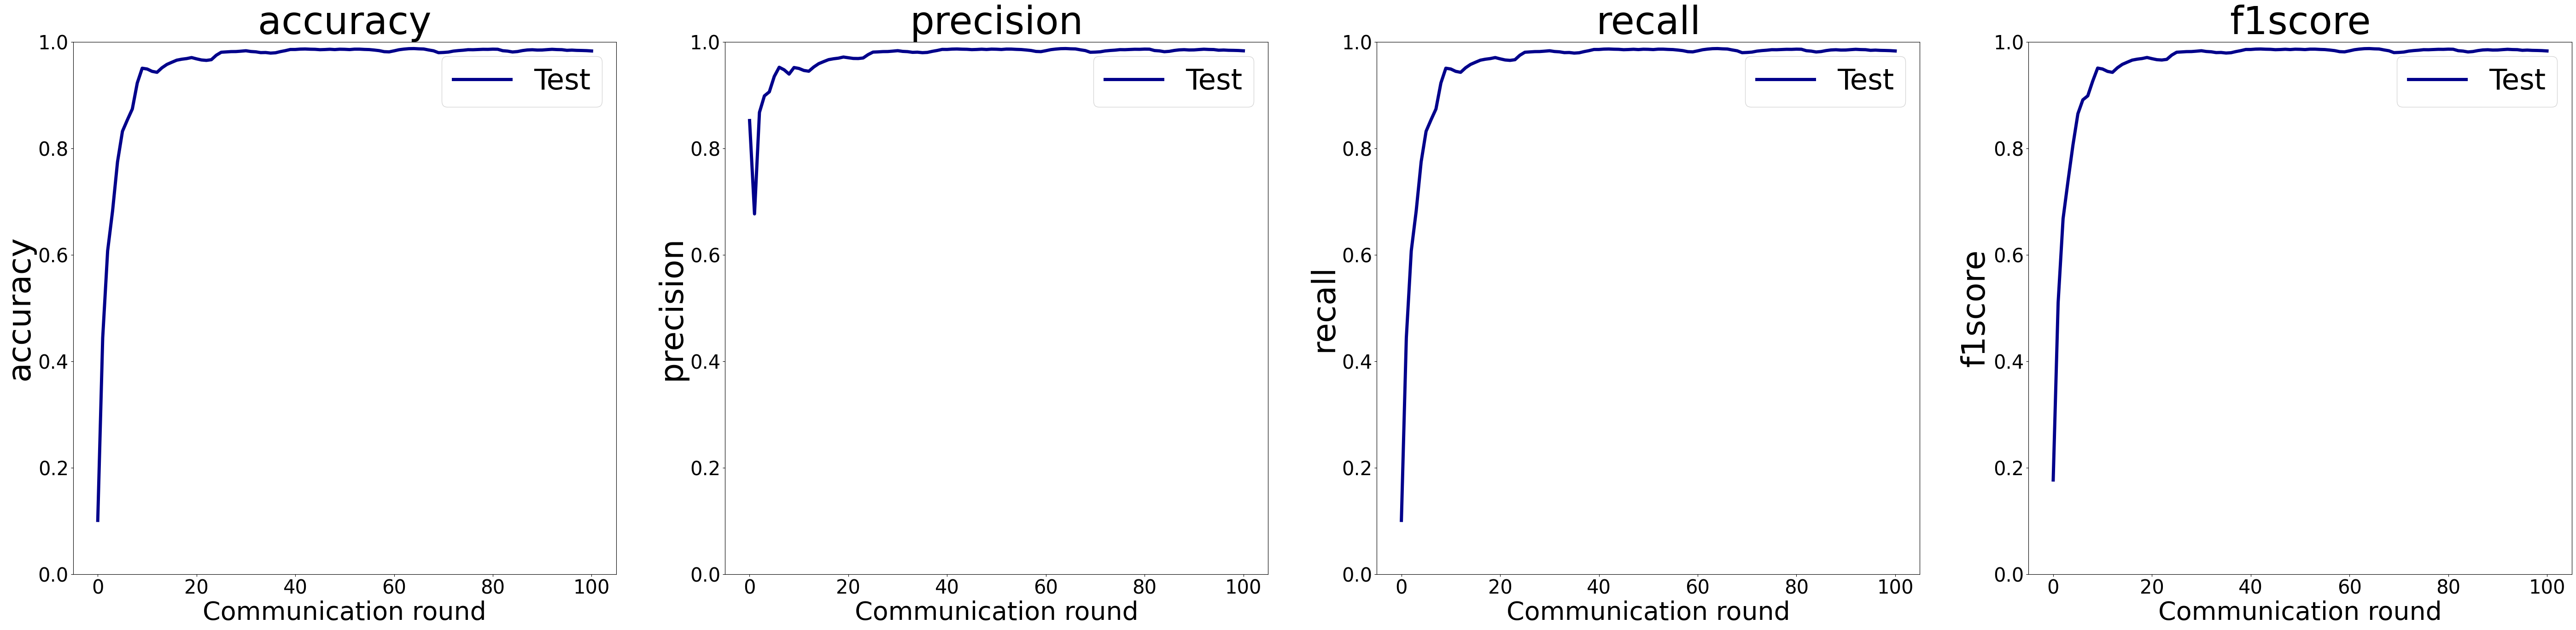

In [13]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])